In [1]:
import pathlib
import matplotlib
from matplotlib import pyplot as plt
import numpy

import glob
import os

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


In [2]:
import matplotlib.font_manager

In [3]:
_GPUS = range(12)
GPUS = [ f"{g//2}.{g%2}" for g in _GPUS ]
print(GPUS)

['0.0', '0.1', '1.0', '1.1', '2.0', '2.1', '3.0', '3.1', '4.0', '4.1', '5.0', '5.1']


In [4]:
CPUS = list(range(0,45,8)) + list(range(52,96,8))
print(CPUS)

[0, 8, 16, 24, 32, 40, 52, 60, 68, 76, 84, 92]


In [5]:
def read_numpy_profile_data(total_ranks, node, GPU, CPU, prefix ="torch/scaling_test_"):
    data_file_name = prefix + node + f"/GPU{GPU}-CPU{CPU}" + f"/profiles/profiling_info_rank_0.npy"
#     print(data_file_name)
    read_in_data = numpy.load(data_file_name)
    
    return read_in_data

In [118]:
NRANKS=984
LOCAL_BATCH_SIZE=12
top_dir = f"/data/datasets/Sunspot/ct_output_multirun/sunspot-a21-single-tile-tensorflow-n{NRANKS}-dfchannels_last-pfloat32-mb{LOCAL_BATCH_SIZE}-synthetic-tile-run1/"
print(top_dir)

/data/datasets/Sunspot/ct_output_multirun/sunspot-a21-single-tile-tensorflow-n984-dfchannels_last-pfloat32-mb12-synthetic-tile-run1/


In [119]:
hosts = glob.glob(top_dir + "/x*")
hosts = [os.path.basename(h) for h in hosts]
print(hosts)

['x1922c3s3b0n0', 'x1922c6s5b0n0', 'x1921c1s4b0n0', 'x1921c6s5b0n0', 'x1922c3s1b0n0', 'x1921c4s1b0n0', 'x1922c0s7b0n0', 'x1921c1s1b0n0', 'x1921c2s5b0n0', 'x1921c6s7b0n0', 'x1922c0s0b0n0', 'x1921c7s6b0n0', 'x1922c5s6b0n0', 'x1922c1s2b0n0', 'x1921c0s4b0n0', 'x1921c3s2b0n0', 'x1922c5s2b0n0', 'x1922c2s3b0n0', 'x1921c4s0b0n0', 'x1922c0s4b0n0', 'x1921c1s2b0n0', 'x1921c5s5b0n0', 'x1922c5s1b0n0', 'x1922c5s0b0n0', 'x1921c7s3b0n0', 'x1921c4s4b0n0', 'x1922c6s4b0n0', 'x1921c5s6b0n0', 'x1922c3s5b0n0', 'x1922c0s5b0n0', 'x1922c7s4b0n0', 'x1922c4s6b0n0', 'x1922c1s7b0n0', 'x1922c4s5b0n0', 'x1922c2s0b0n0', 'x1922c7s0b0n0', 'x1922c0s2b0n0', 'x1921c6s1b0n0', 'x1921c3s6b0n0', 'x1922c3s2b0n0', 'x1921c4s7b0n0', 'x1921c5s4b0n0', 'x1921c2s3b0n0', 'x1921c1s3b0n0', 'x1922c2s1b0n0', 'x1921c3s4b0n0', 'x1921c6s2b0n0', 'x1921c6s3b0n0', 'x1922c7s3b0n0', 'x1921c2s0b0n0', 'x1921c4s6b0n0', 'x1921c2s7b0n0', 'x1921c5s7b0n0', 'x1922c3s4b0n0', 'x1922c6s2b0n0', 'x1922c5s3b0n0', 'x1921c7s0b0n0', 'x1922c5s7b0n0', 'x1922c1s1b0n

In [120]:
data = read_numpy_profile_data(384, hosts[0], GPUS[0], CPUS[0], prefix=top_dir)

In [121]:
print(data.dtype)

[('i', '<i4'), ('start', '<M8[us]'), ('iteration', '<m8[us]'), ('train', '<m8[us]'), ('val', '<m8[us]'), ('io', '<m8[us]'), ('forward', '<m8[us]'), ('backward', '<m8[us]'), ('checkpoint', '<m8[us]'), ('loss', '<m8[us]'), ('summary', '<m8[us]'), ('log', '<m8[us]'), ('optimizer', '<m8[us]'), ('metrics', '<m8[us]')]


In [122]:
host_vals  = []
host_index = []
gpu_index  = []
gpu_vals   = []
throughputs = []
variation  = []
start_time = []
all_imgs   = []

for i_host, host in enumerate(hosts):
    for i_gpu, GPU in enumerate(GPUS):
        try:
            this_data = read_numpy_profile_data(NRANKS, host, GPU, CPUS[i_gpu], prefix=top_dir)
        except:
            print(f"Host {host} and GPU {GPU} FAILED")
            continue
            
        start_time.append( this_data[0]['start'] )
        # Compute img/s for each iteration:
        img_per_s = LOCAL_BATCH_SIZE / (1e-6*this_data['iteration'][2:].astype(float) )
        
        # Compute throughput as total time / total iterations
        total_time = 1e-6*numpy.sum(this_data['iteration'][2:].astype(float))
        total_iterations = len(this_data['iteration'][2:])

        this_throughput = LOCAL_BATCH_SIZE * total_iterations / total_time
            
        average_img_per_s = numpy.mean(img_per_s)
        var_img_per_s     = numpy.std(img_per_s)
#         print(this_throughput)
#         print(average_img_per_s)
        
        
        host_index.append(i_host)
        gpu_index.append(i_gpu)
        gpu_vals.append(GPU)
        host_vals.append(host)
        throughputs.append(average_img_per_s)
        variation.append(var_img_per_s)
        all_imgs.append(img_per_s)
# throughput = len(data['iteration'][2:]) * LOCAL_BATCH_SIZE / numpy.sum(numpy.cast(data['iteration'][2:].cast(numpy.float))
# print(throughput)

In [123]:
import pandas as pd
df = pd.DataFrame(zip(host_index, host_vals, gpu_index, gpu_vals, throughputs, all_imgs, variation, start_time), 
                  columns=["i_Host", "Host", "i_GPU", "GPU", "Throughput", "Throughputs", "Uncert", "Start"])

In [124]:
# add a column for the tile:
df['tile'] = df['i_GPU'] % 2 == 0

In [125]:
print(df)

     i_Host           Host  i_GPU  GPU  Throughput  \
0         0  x1922c3s3b0n0      0  0.0   18.677537   
1         0  x1922c3s3b0n0      1  0.1   18.907357   
2         0  x1922c3s3b0n0      2  1.0   19.156172   
3         0  x1922c3s3b0n0      3  1.1   19.151562   
4         0  x1922c3s3b0n0      4  2.0   19.315573   
..      ...            ...    ...  ...         ...   
979      81  x1922c7s5b0n0      7  3.1   18.903502   
980      81  x1922c7s5b0n0      8  4.0   18.907646   
981      81  x1922c7s5b0n0      9  4.1   18.882533   
982      81  x1922c7s5b0n0     10  5.0   18.561674   
983      81  x1922c7s5b0n0     11  5.1   18.609601   

                                           Throughputs    Uncert  \
0    [18.675269740927323, 18.97161214436132, 18.847...  0.494371   
1    [19.990238100394308, 19.870345992399592, 19.21...  0.441154   
2    [19.131493946476457, 19.091772559713498, 19.02...  0.201541   
3    [19.693277207493292, 19.650065090840616, 19.44...  0.212194   
4    [18.79

In [126]:
print(len(host_vals))
print(len(gpu_vals))

984
984


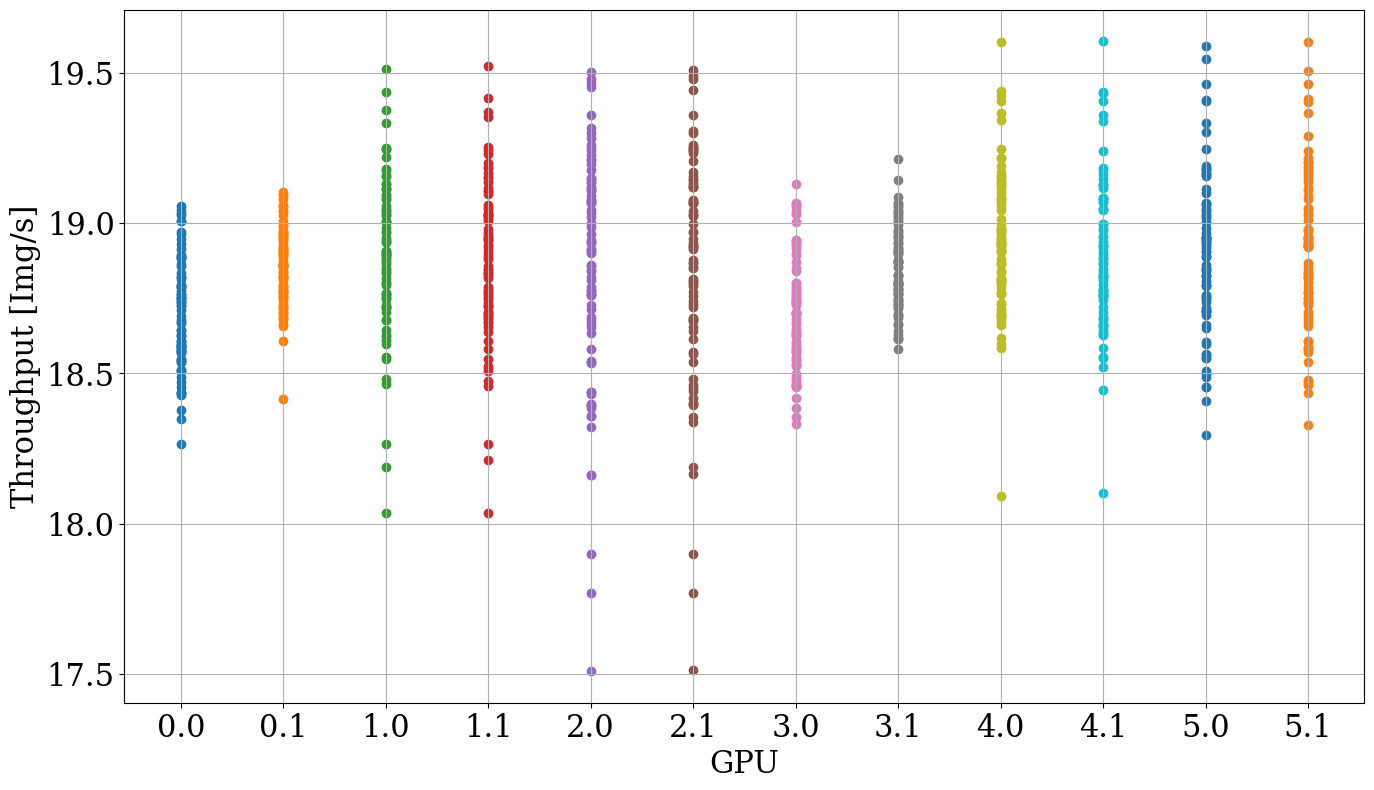

In [162]:
# Plot the gpu-to-gpu variation

fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(projection='3d')

bin_size = 0.1
bins = numpy.arange(17,21,bin_size)

host = hosts[2]

for i, gpu in enumerate(GPUS):
    sub_df = df.query(f"i_GPU == {i}")
    throughputs = sub_df['Throughputs'].values
    throughputs = numpy.concatenate(throughputs)
#     print(throughputs)
    counts, bin_edges = numpy.histogram(throughputs, bins=bins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_widths  = bin_edges[1:] - bin_edges[:-1]
#     print(counts)
    
    gpu_loc = [i for c in counts ]
    
#     color = 256*numpy.random.rand(3,)
#     print(color)
#     ax.bar3d(bin_centers, gpu_loc, [0 for c in counts], dx=bin_size, dy=0.5, dz=counts) 
#     ax.bar3d(gpu_loc, bin_centers, counts, dx=1, dy=1, dz=bin_widths)
#     ax.bar3d(gpu_loc, counts, bin_centers, dx=1, dy=1, dz=bin_widths)
#     ax.bar3d(counts, gpu_loc, bin_centers, dx=1, dy=1, dz=bin_widths)
#     ax.bar3d(bin_centers, counts, gpu_loc, dx=1, dy=1, dz=bin_widths)
#     ax.bar3d(counts, bin_centers, gpu_loc, dx=1, dy=1, dz=bin_widths)
    plt.scatter(sub_df['GPU'], sub_df["Throughput"])
#     break
    
# plt.scatter(gpu_vals, throughputs)

plt.xlabel("GPU")
plt.ylabel("Throughput [Img/s]")
plt.grid(True)
plt.show()

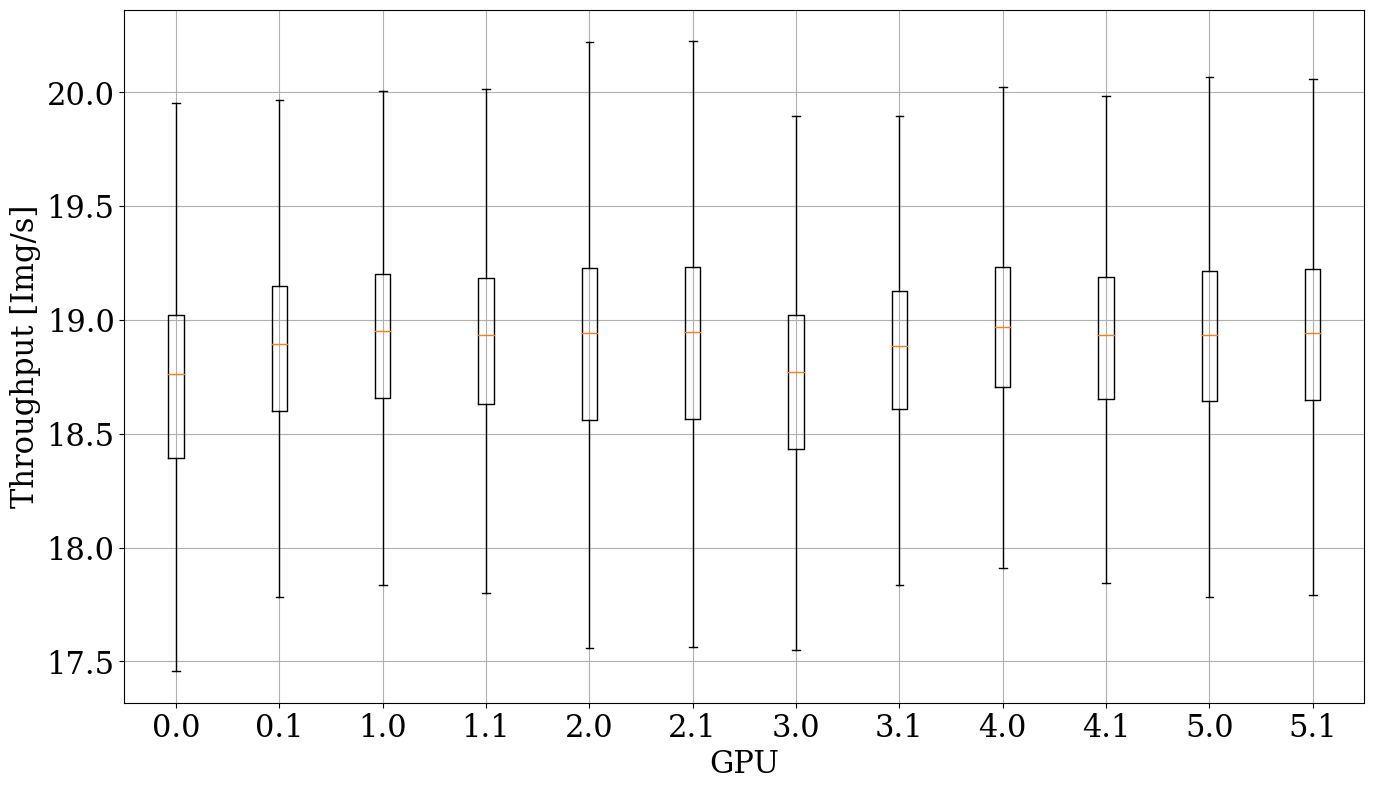

In [151]:
# Plot the gpu-to-gpu variation

fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(projection='3d')

bin_size = 0.1
bins = numpy.arange(17,21,bin_size)

for i, gpu in enumerate(GPUS):
    sub_df = df.query(f"i_GPU == {i}")
    throughputs = sub_df['Throughputs'].values
    throughputs = numpy.concatenate(throughputs)
#     print(throughputs)
    counts, bin_edges = numpy.histogram(throughputs, bins=bins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_widths  = bin_edges[1:] - bin_edges[:-1]
#     print(counts)
    
    gpu_loc = [i for c in counts ]
    
#     color = 256*numpy.random.rand(3,)
    plt.boxplot(throughputs, positions=(i,), showfliers=False)
#     break
    
# plt.scatter(gpu_vals, throughputs)

plt.xticks(range(12), GPUS)
plt.xlabel("GPU")
plt.ylabel("Throughput [Img/s]")
plt.grid(True)
plt.show()

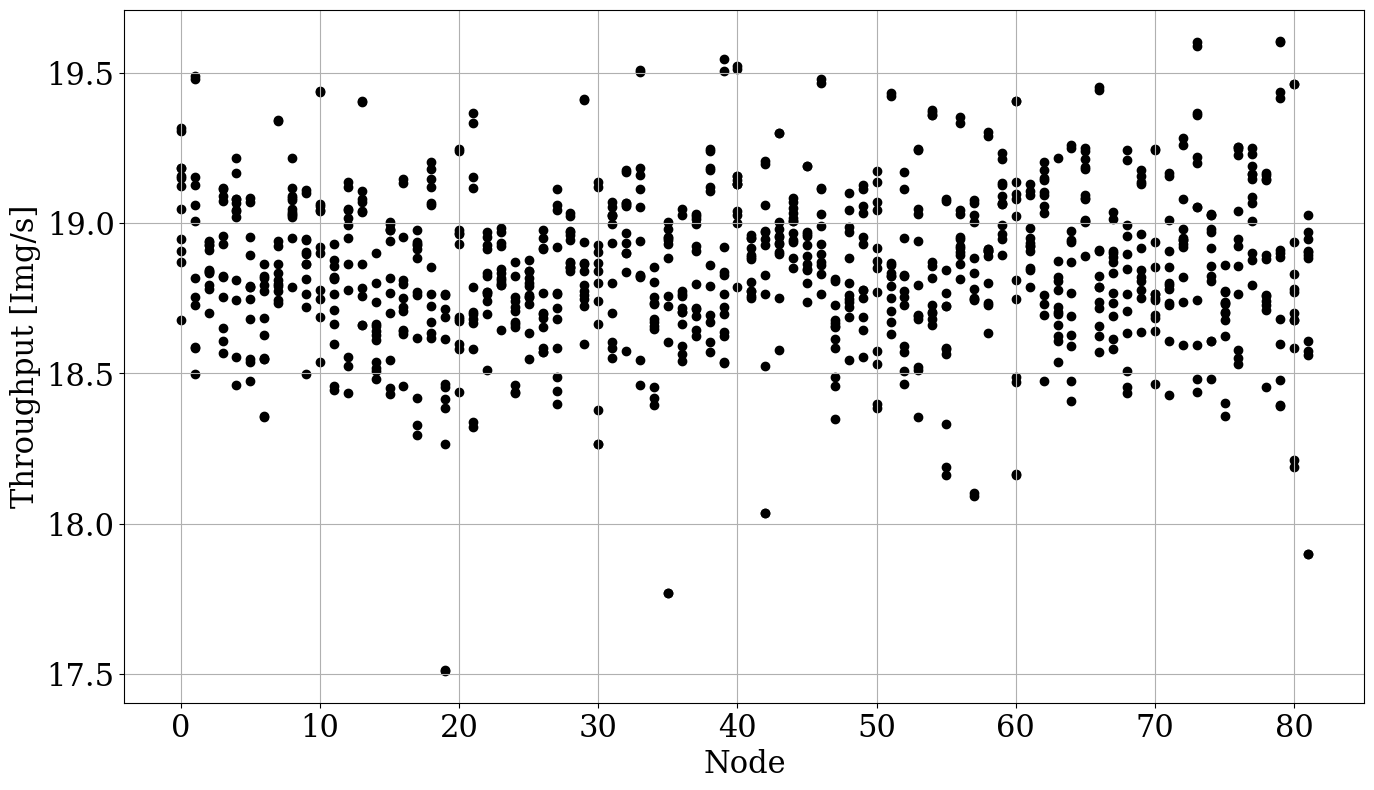

In [163]:
# Plot the gpu-to-gpu variation

fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(projection='3d')

bin_size = 0.1
bins = numpy.arange(17,21,bin_size)

plt.scatter(df['i_Host'], df['Throughput'], marker='o', color='black')
# plt.errorbar(df['i_Host'], df['Throughput'], yerr=df['Uncert'], fmt="none")

# for i, host in enumerate(hosts):
#     sub_df = df.query(f"Host == \"{host}\"")
#     throughputs = sub_df['Throughputs'].values
#     throughputs = numpy.concatenate(throughputs)
# #     print(throughputs)
#     counts, bin_edges = numpy.histogram(throughputs, bins=bins)
#     bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
#     bin_widths  = bin_edges[1:] - bin_edges[:-1]
# #     print(counts)
    
#     gpu_loc = [i for c in counts ]
    
# #     color = 256*numpy.random.rand(3,)
#     plt.error(throughputs, positions=(i,), showfliers=False)
# #     break
    
# plt.scatter(gpu_vals, throughputs)

# plt.xticks(range(12), GPUS)
plt.xlabel("Node")
plt.ylabel("Throughput [Img/s]")
plt.grid(True)
plt.show()

[    3     6     6     2     5     5     4     2    10     3     5     3
     5    10     2     9     9     6    11     9    16    32    81   185
   309   578  1131  1969  3511  4922  6265  7107  7828  9178 10437 12576
 15721 19905 23292 24319 22610 20346 17611 13872  9615  5947  3087  1315
   562   210   129   109    47    23    10     2     1     1     0]
[    2     3     2     2     3     5     6     1     5     3     3     6
     4     1     2     4     2     9     7    10    17    19    62   128
   161   289   638  1372  2495  3841  5012  5962  7092  8448  9989 12611
 15814 20015 23187 24580 23697 21840 19186 15101 10744  6484  3598  1588
   586   213    78    22    15     4     2     0     0     0     0]


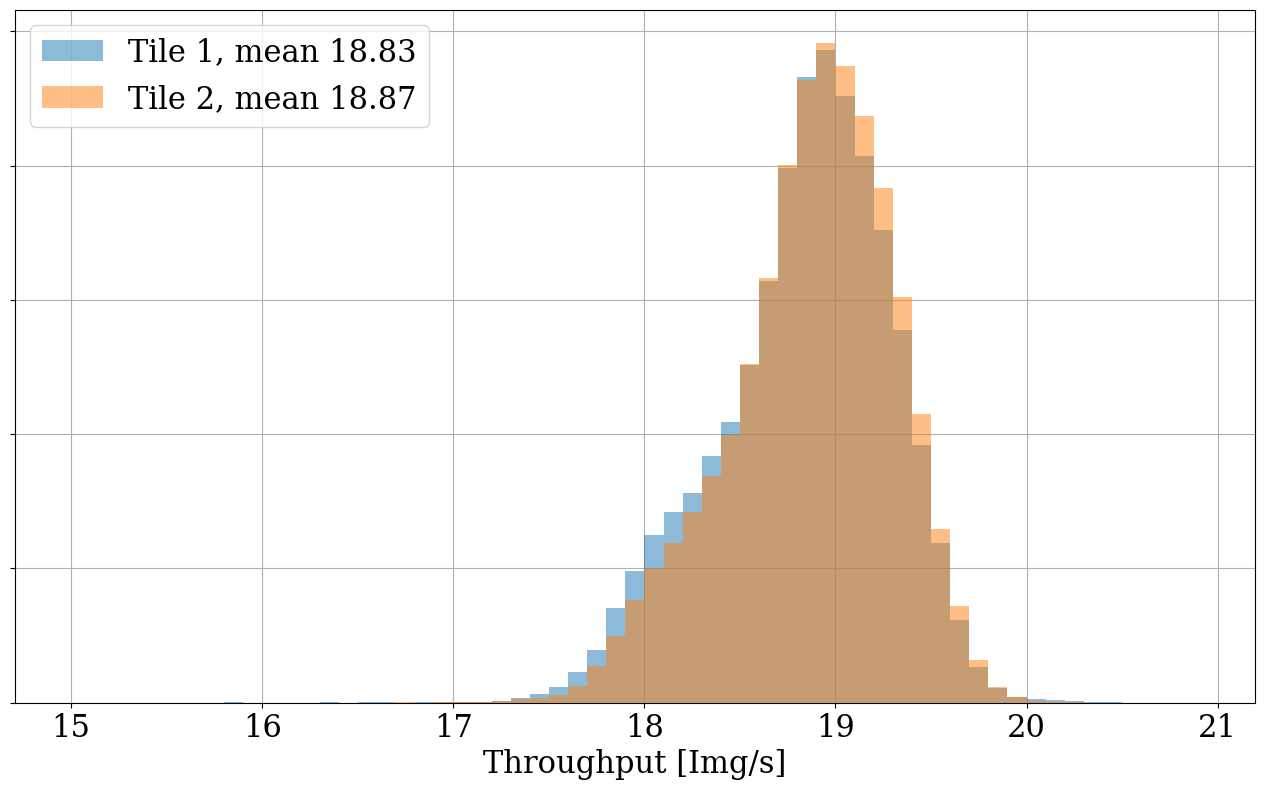

In [183]:
# Make a histogram of the iteration times

fig = plt.figure(figsize=(16,9))

bins = numpy.arange(15,21,0.1)

throughputs_t1 = numpy.concatenate(df.query("tile")['Throughputs'].values)
throughputs_t2 = numpy.concatenate(df.query("tile == False")['Throughputs'].values)
#     print(throughputs)
# counts, bin_edges = numpy.histogram(throughputs, bins=bins)

counts_t1, bin_edges = numpy.histogram(throughputs_t1, bins=bins)
counts_t2, bin_edges = numpy.histogram(throughputs_t2, bins=bins)
print(counts_t1)
print(counts_t2)

mean_t1 = numpy.mean(df.query("tile")["Throughput"])
mean_t2 = numpy.mean(df.query("tile == False")["Throughput"])


bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
widths = bin_edges[1:] - bin_edges[:-1]
plt.bar(bin_centers, counts_t1, width=widths, zorder=3, label=f"Tile 1, mean {mean_t1:.2f}", alpha=0.5)
plt.bar(bin_centers, counts_t2, width=widths, zorder=3, label=f"Tile 2, mean {mean_t2:.2f}", alpha=0.5)
plt.grid(zorder=0)
plt.legend()
plt.xlabel("Throughput [Img/s]")
plt.gca().tick_params(labelleft=False) 
plt.show()

In [185]:
import scipy

norm = scipy.stats.norm

In [218]:
# Make a histogram of the iteration times


fom_per_tile = df['Throughput'].values
#     print(throughputs)
# counts, bin_edges = numpy.histogram(throughputs, bins=bins)

fit = norm.fit(fom_per_tile)
print(fit)
norm(*fit).pdf(18.5)

norm(*fit).rvs()

(18.853618985696063, 0.2664278308825816)


18.772653809167604

18.853618985696063
0.9286918389582859


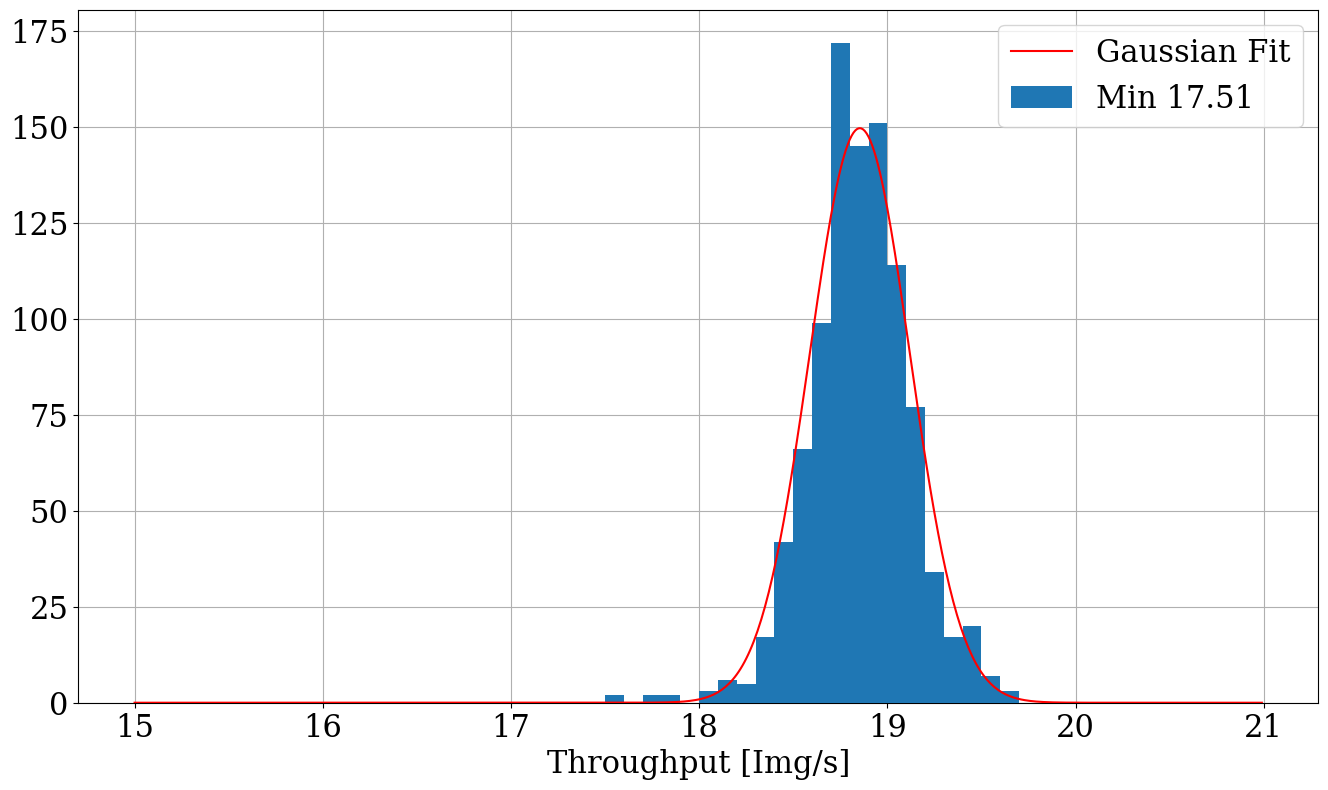

In [250]:

fig = plt.figure(figsize=(16,9))

bins = numpy.arange(15,21,0.1)

counts, bin_edges = numpy.histogram(fom_per_tile, bins=bins)
min_fom = numpy.min(fom_per_tile)

x = numpy.arange(15,21,0.01)

mean_fom = numpy.mean(fom_per_tile)
print(mean_fom)
print(min_fom / mean_fom)

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
widths = bin_edges[1:] - bin_edges[:-1]
plt.bar(bin_centers, counts, width=widths, zorder=3, label=f"Min {min_fom:.2f}")
plt.plot(x, 100*norm(*fit).pdf(x), zorder=4, color="red", label="Gaussian Fit")
plt.grid(zorder=0)
plt.legend()
plt.xlabel("Throughput [Img/s]")
# plt.gca().tick_params(labelleft=False) 
plt.show()

1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
[1.0, 0.9932980169186202, 0.9946650159373714, 0.9915687097622213, 0.9935769227672405, 0.9949114927258683, 0.9867737665167859, 0.9797659103041062, 0.9758711009928122, 0.9756053070617899, 0.9532561901579288, 0.9733891589237416, 0.9572508407892371, 0.9658450045117802]


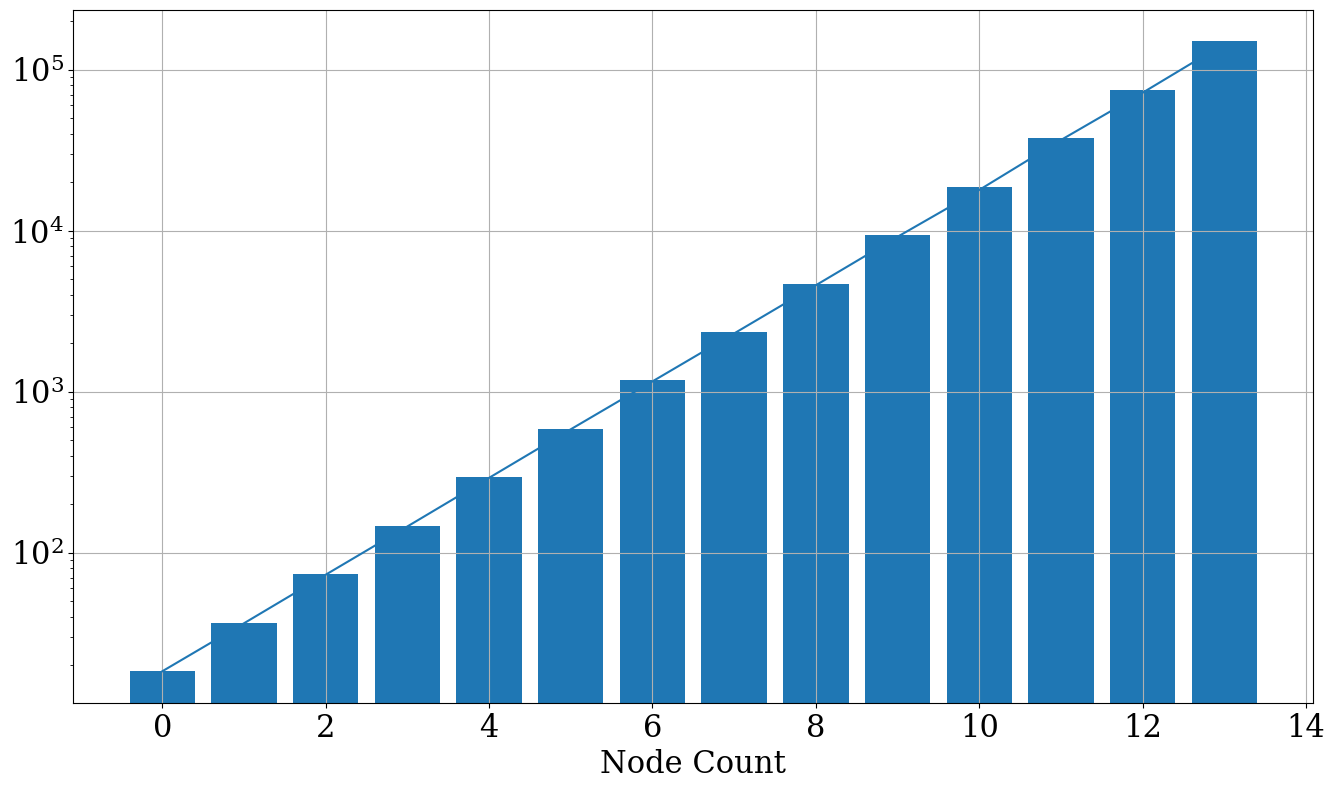

In [248]:
powers = numpy.arange(14)

scale = []
fom = []

for i in powers:
    
    this_scale = 2**i
    print(this_scale)
    
    n_gpus = 12*(this_scale)
    foms = norm(*fit).rvs(size=n_gpus)
#     print(foms)
    min_fom = min(foms)
    scale.append(this_scale)
    fom.append(min_fom*this_scale)
#     print(min_fom)    
    
fig = plt.figure(figsize=(16,9))

x = range(len(scale))

ideal = [s*fom[0] for s in scale]

ratio = [ f / i for f, i in zip(fom, ideal)]
print(scale)
print(ratio)

plt.grid()
plt.xlabel("Node Count")
plt.plot(x, fom)
plt.bar(x, ideal)

plt.yscale("log")

plt.show()

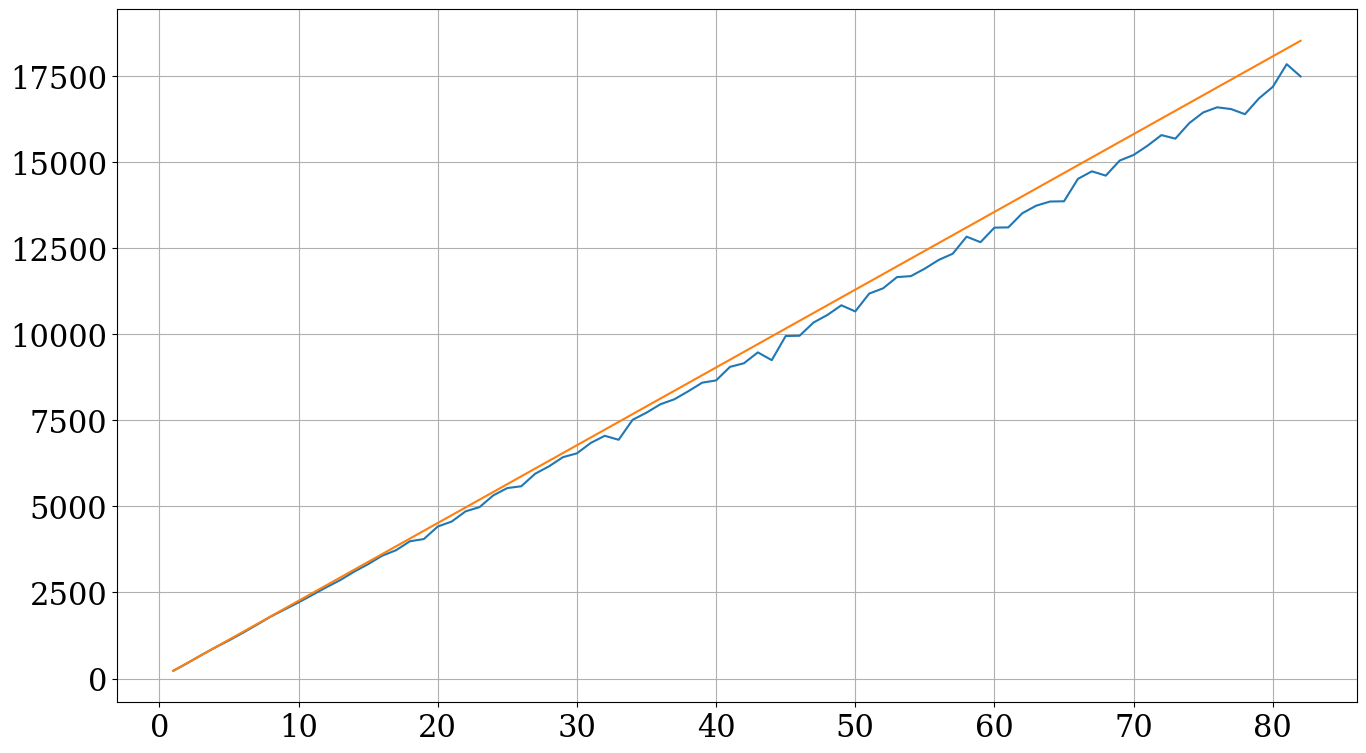

In [177]:
# Compute the FOM as a function of run size, randomizing the selected nodes

size = []
fom  = []

n_trials=50
for i_trial in range(50)

for i in range(82):
    sub_df = df.sample(i+1)
    min_throughput = sub_df["Throughput"].min()
#     print(min_throughput)
    FOM = LOCAL_BATCH_SIZE * min_throughput * (i+1)
#     print(FOM)

    size.append(i+1)
    fom.append(FOM)
    
fig = plt.figure(figsize=(16,9))
linear = [s*fom[0] for s in size]
plt.plot(size,fom, label="FOM")
plt.plot(size,linear, label="Linear Scaling")

plt.grid()
plt.show()

In [129]:
def analyze_iteration(arr):
    print(f"  Mean time: {numpy.mean(arr):.3f} +/- {numpy.std(arr):.3f}")
    print(f"  Median time: {numpy.median(arr):.3f}")
    print(f"  Max time: {numpy.max(arr):.3f} ({numpy.argmax(arr)})")
    print(f"  50/75/90/95 quantile: {numpy.quantile(arr, [0.5, 0.75, 0.9, 0.95])}")


In [130]:
def plot_run_data(plot_name, title, _profile_data):
    # How much time in forward pass?
    conversion = 1e-6
    
#     print("IO: ")
#     analyze_iteration(conversion * _profile_data['io'].astype("float"))
#     print("Step: ")
#     analyze_iteration(conversion * _profile_data['optimizer'].astype("float"))
#     print("Forward: (estimated)")
#     analyze_iteration(conversion * _profile_data['forward'].astype("float"))
#     print("Backward: ")
#     analyze_iteration(conversion * _profile_data['backward'].astype("float"))


    # Create histograms for the various timings.
    fig = plt.figure(figsize=(16,9))

    biggest_m = None
    
    colors = ('tab:blue', 'tab:orange', 'tab:green',
             'tab:red', 'tab:purple', 'tab:brown',
             'tab:pink', 'tab:gray', 'tab:olive',
             'tab:cyan')


    keys = [
        "forward", "backward", 
        "val",
        "io", "checkpoint",
        "loss", "summary",
        "log", "optimizer",
        "metrics"]
    
    for array_key, color in zip(keys, colors):

        array = conversion * _profile_data[array_key].astype("float")
        
        # This is the biggest time for this run.
        m = numpy.min([numpy.max([numpy.max(array), 1.0]), 2.3])
        # Bins for the histogram:
        bins = numpy.arange(0,1.01*m, 0.01)

        if biggest_m is None:
            biggest_m = m
        else:
            if m > biggest_m:
                biggest_m = m

        hist, bin_edges = numpy.histogram(array, bins=bins)
        # Make it a normalized percentage:
        hist = 100.*hist / len(array)

        # Compute the middle locations:
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        bin_widths = bin_edges[1:] - bin_edges[:-1]

        # Plot the timing info:
        plt.plot(bin_centers, hist, lw=2, label = array_key, color = color)


        # Compute quantiles:
        quant_bins = numpy.arange(0,1.01, 0.01)
        # print(quant_bins)
        quantiles = numpy.quantile(array, quant_bins)
        # print(quantiles)

        # Add one more bin to the quantiles to make it finish the plot:
        quant_bins = numpy.append(quant_bins, 1.00)
        quantiles  = numpy.append(quantiles, m+0.1)


        plt.plot(quantiles, 100*quant_bins, lw=1, ls="--", color = color)


    plt.xlabel("Time [s]", fontsize=22)
    plt.ylabel("Normalized Distribution [%]", fontsize=22)
    plt.grid(True)
    plt.ylim([0,101])
    plt.xlim([0, 0.5])
    plt.legend(fontsize=22)
    plt.title(title, fontsize=22)
    plt.savefig(f"{plot_name}.pdf")


## PyTorch base runs on 1 node:

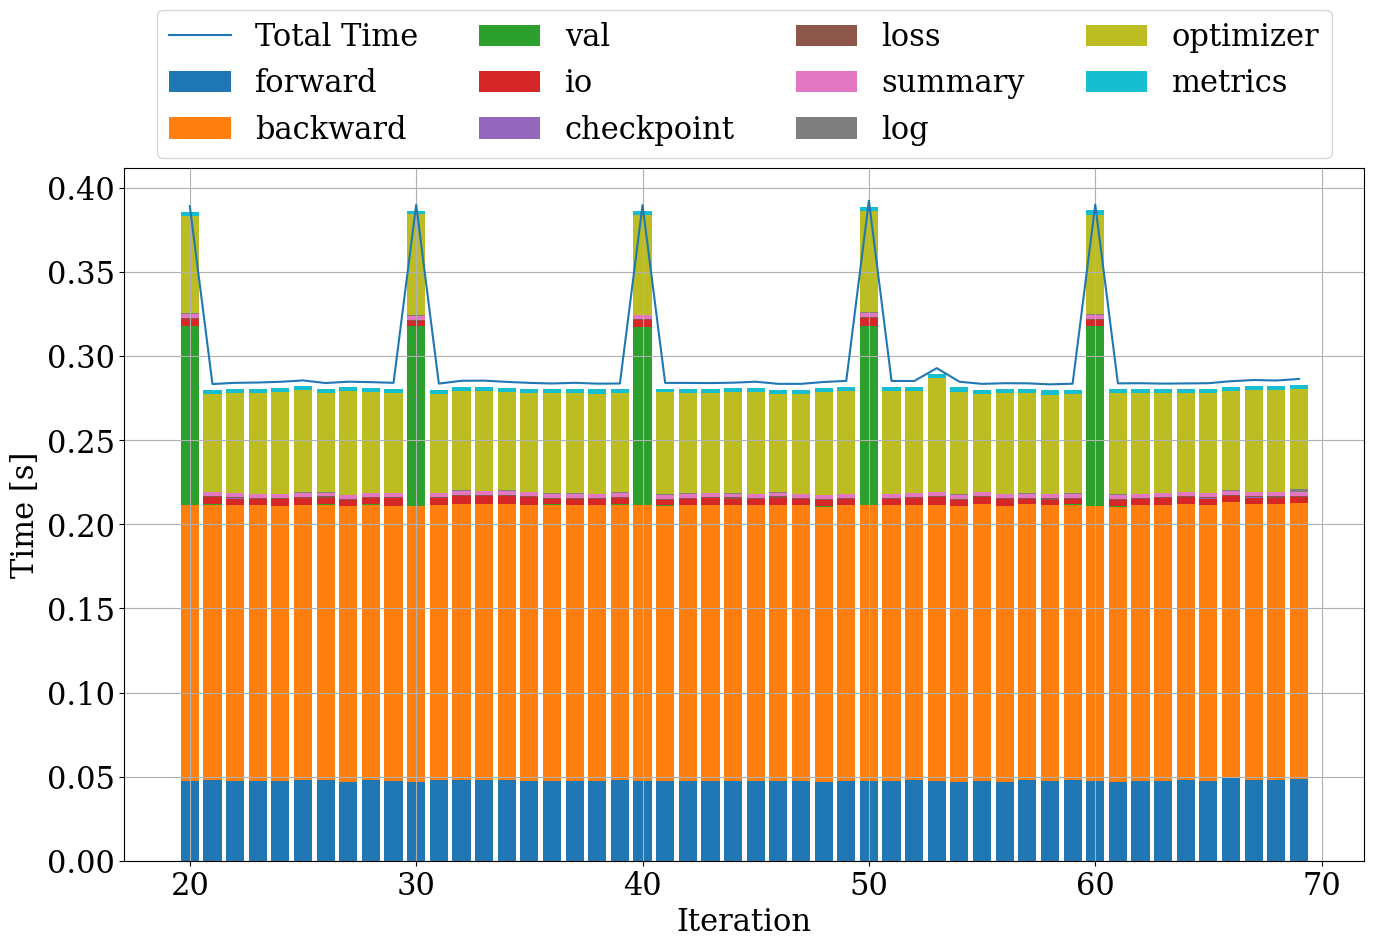

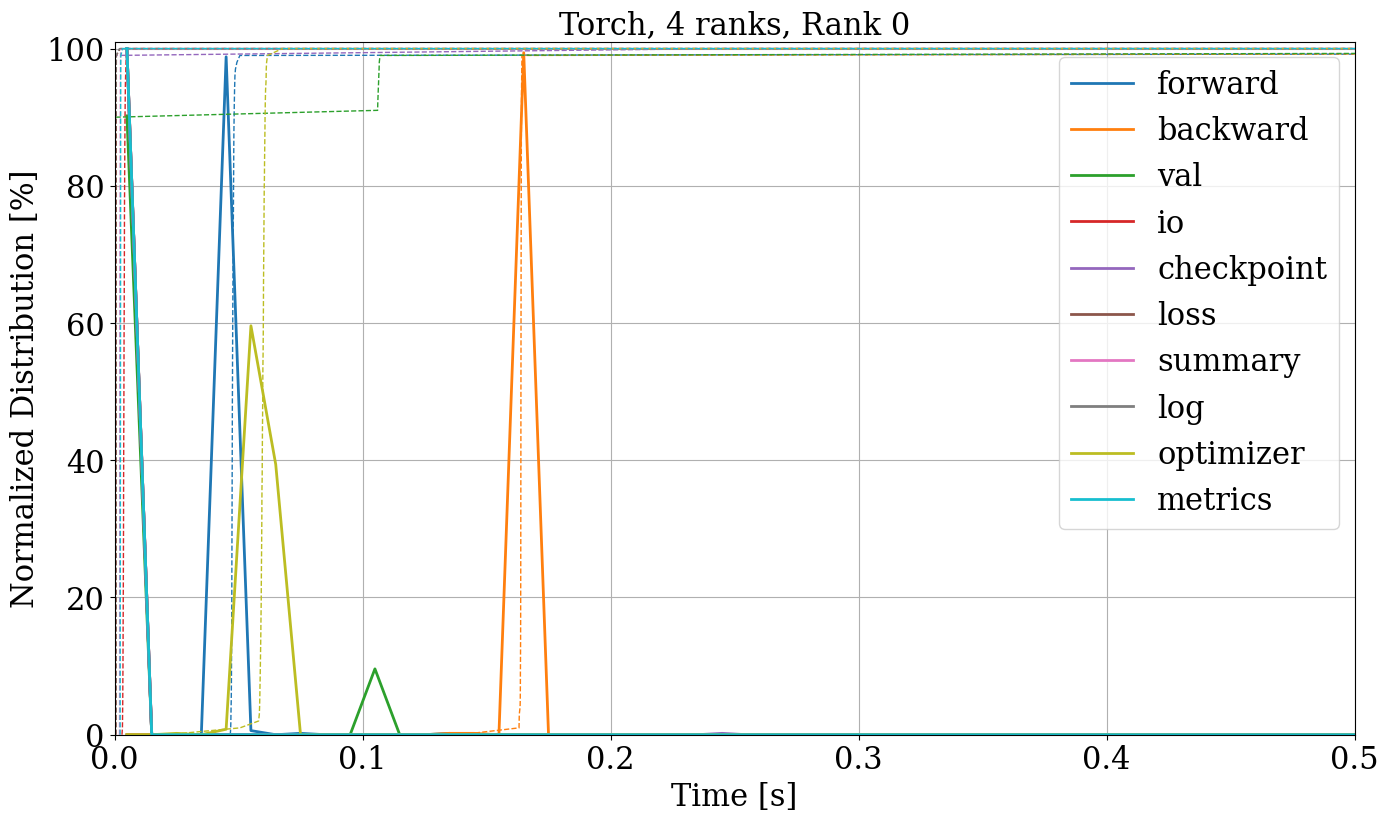

In [10]:
rank = 0
data = read_numpy_profile_data(4,1,rank,prefix=top_dir+"/torch/scaling_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"torch_4_1_{rank}",f"Torch, 4 ranks, Rank {rank}", data)


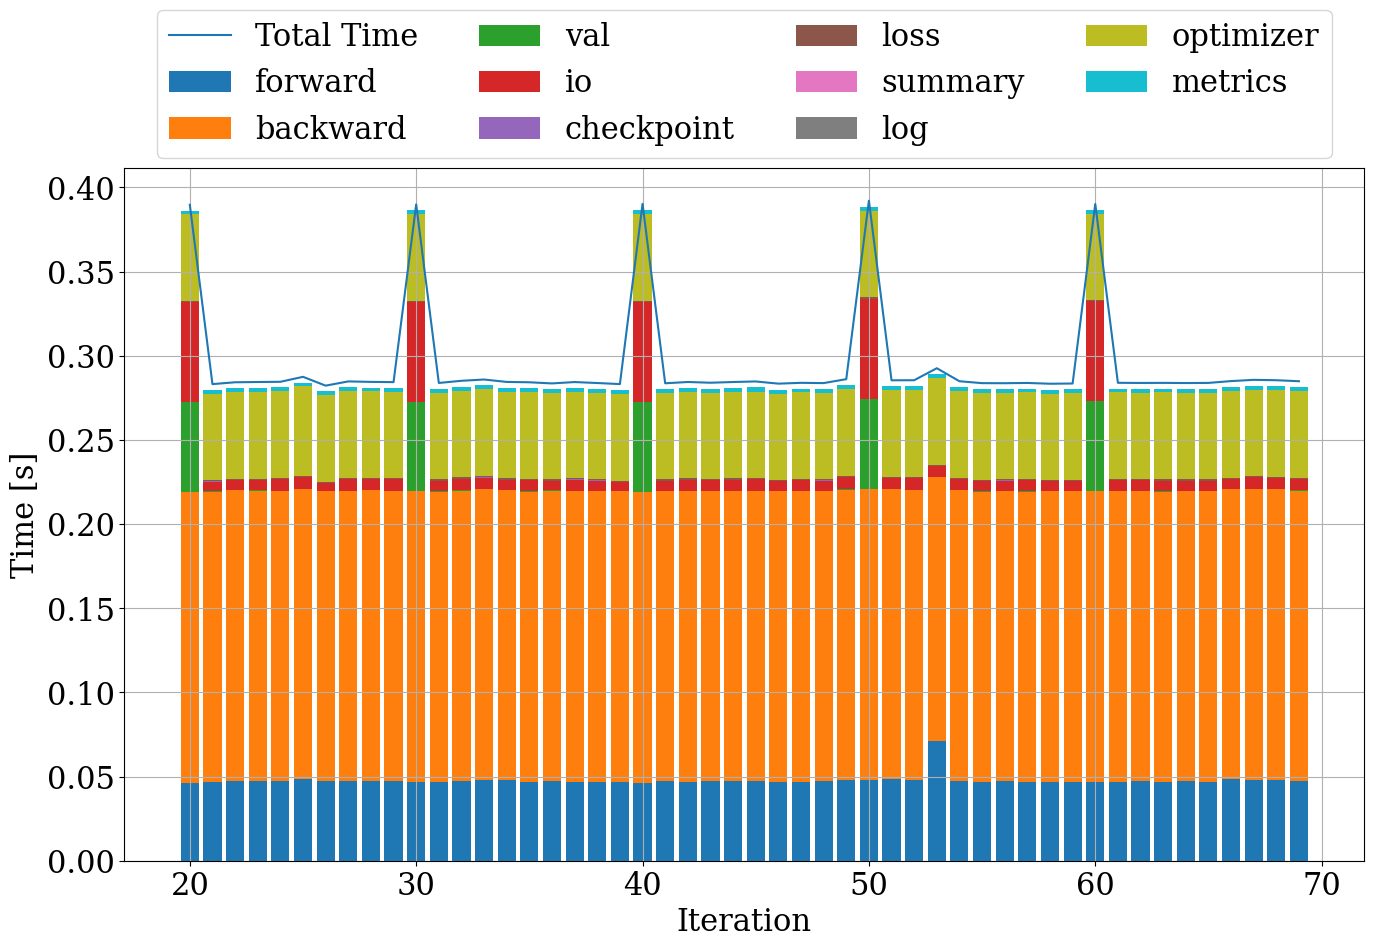

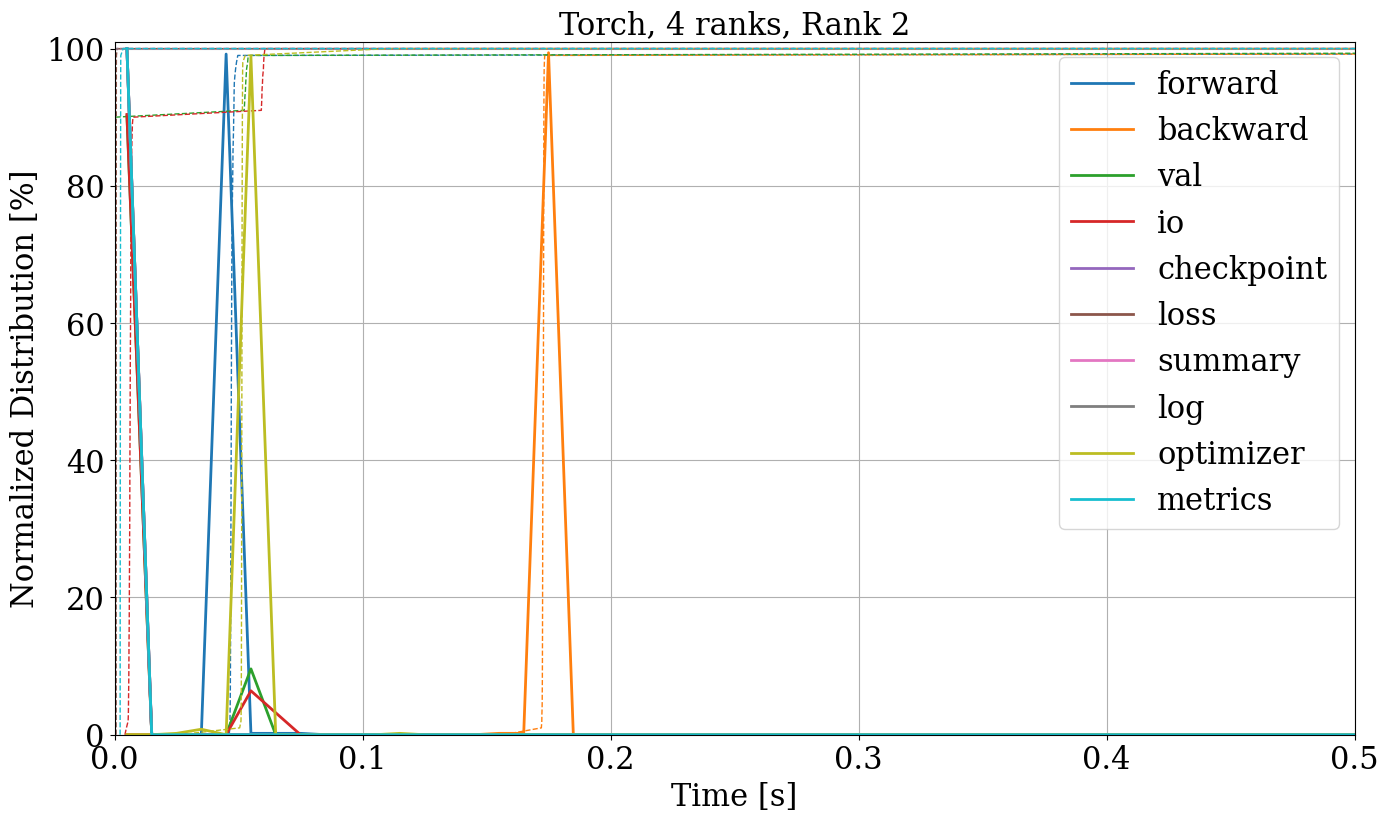

In [11]:
rank = 2
data = read_numpy_profile_data(4,1,rank,prefix=top_dir+"/torch/scaling_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"torch_4_1_{rank}",f"Torch, 4 ranks, Rank {rank}", data)


## Tensorflow Baseline Runs

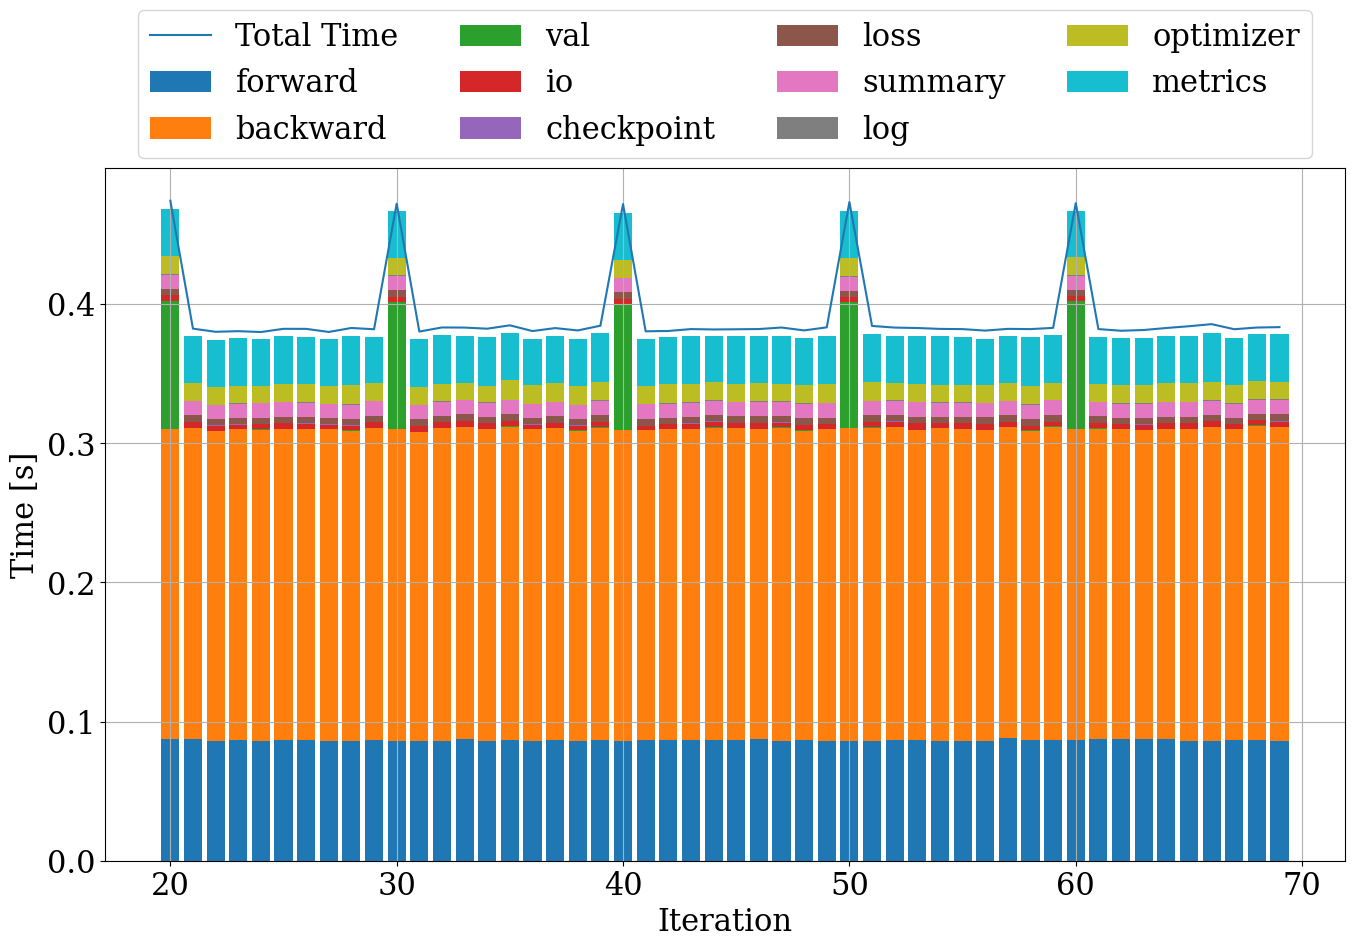

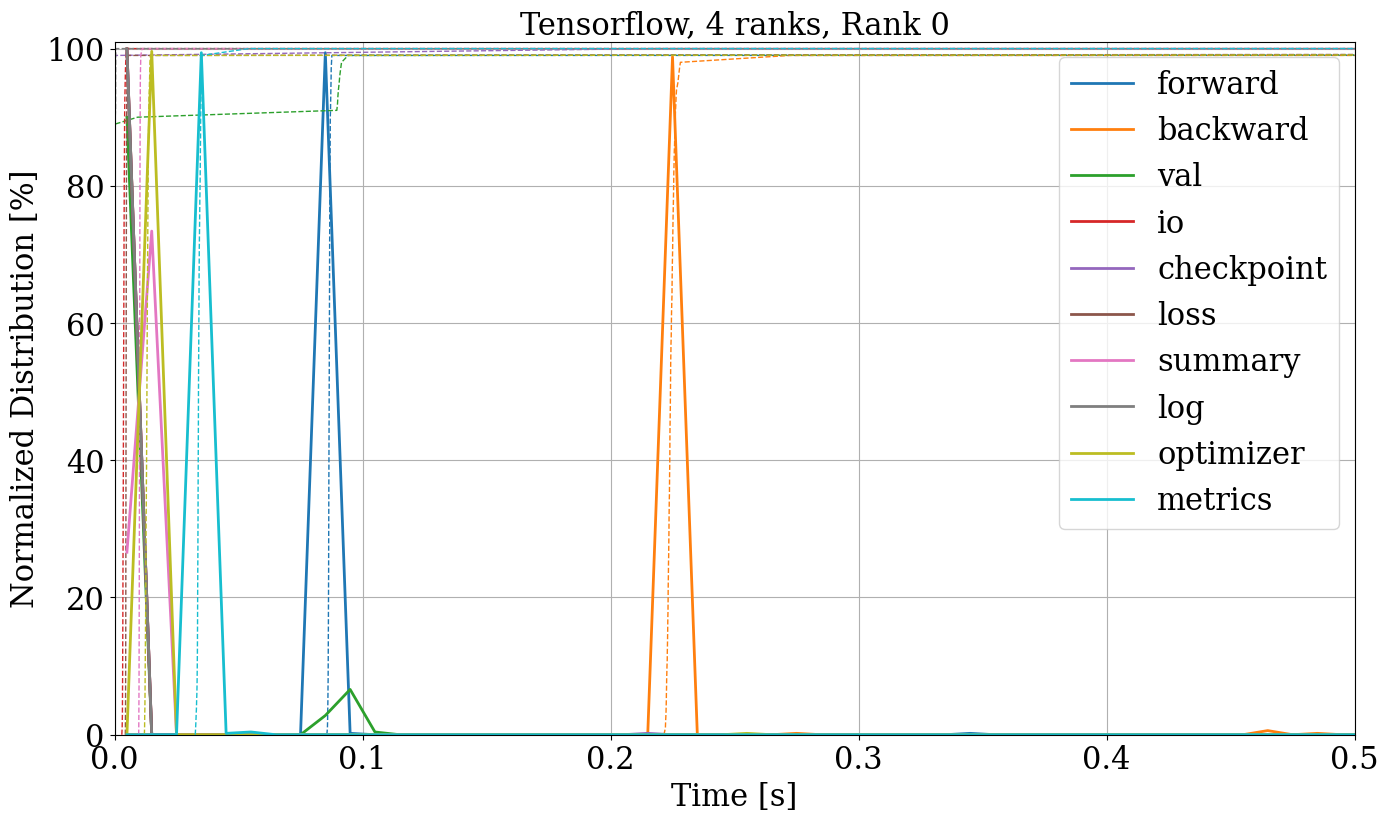

In [12]:
rank = 0
data = read_numpy_profile_data(4,1,rank,prefix=top_dir+"/tensorflow/scaing_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"tf_4_1_{rank}",f"Tensorflow, 4 ranks, Rank {rank}", data)


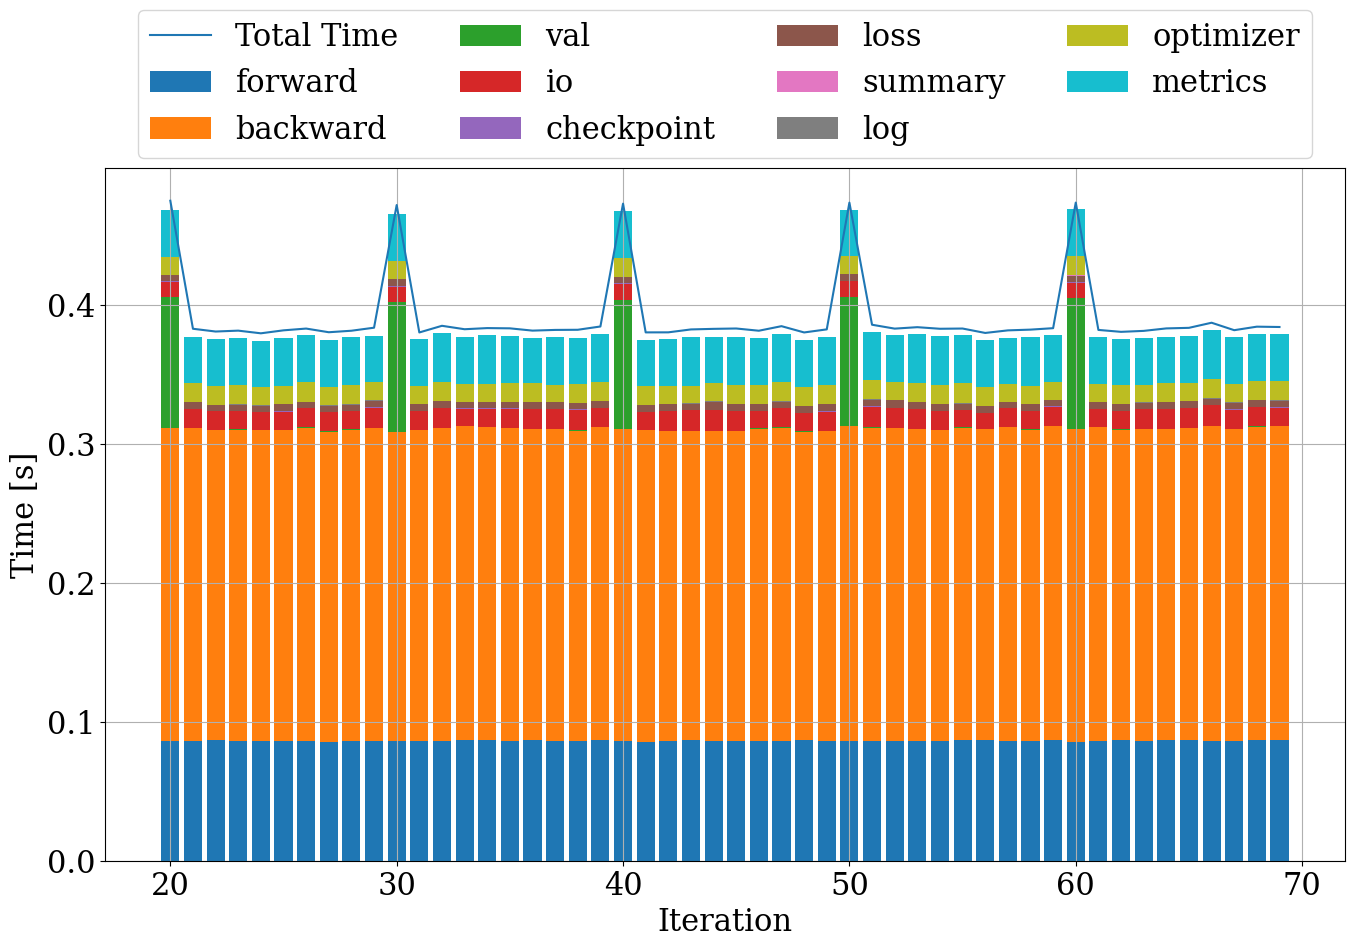

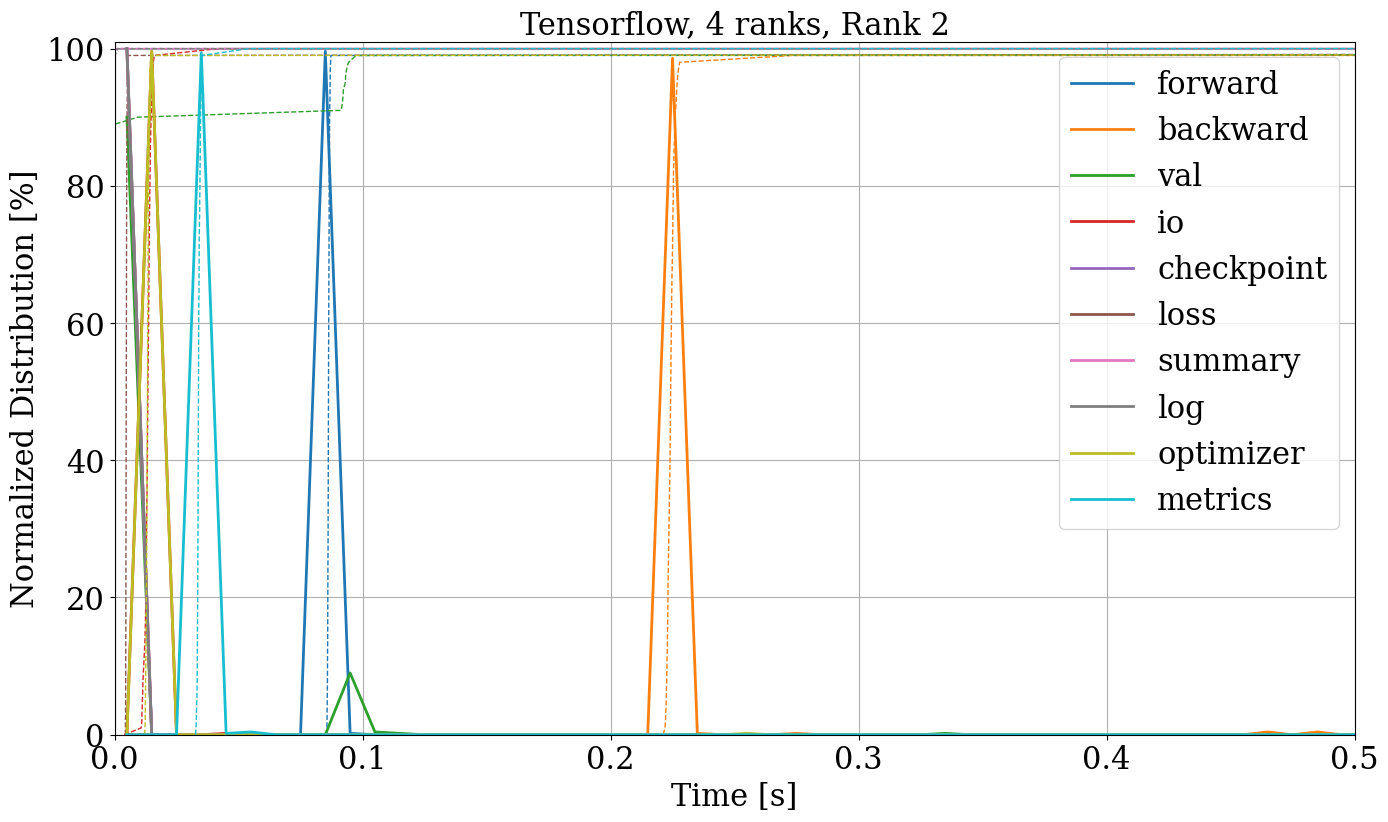

In [13]:
rank = 2
data = read_numpy_profile_data(4,1,rank,prefix=top_dir+"/tensorflow/scaing_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"tf_4_1_{rank}",f"Tensorflow, 4 ranks, Rank {rank}", data)


## Pytorch at Scale

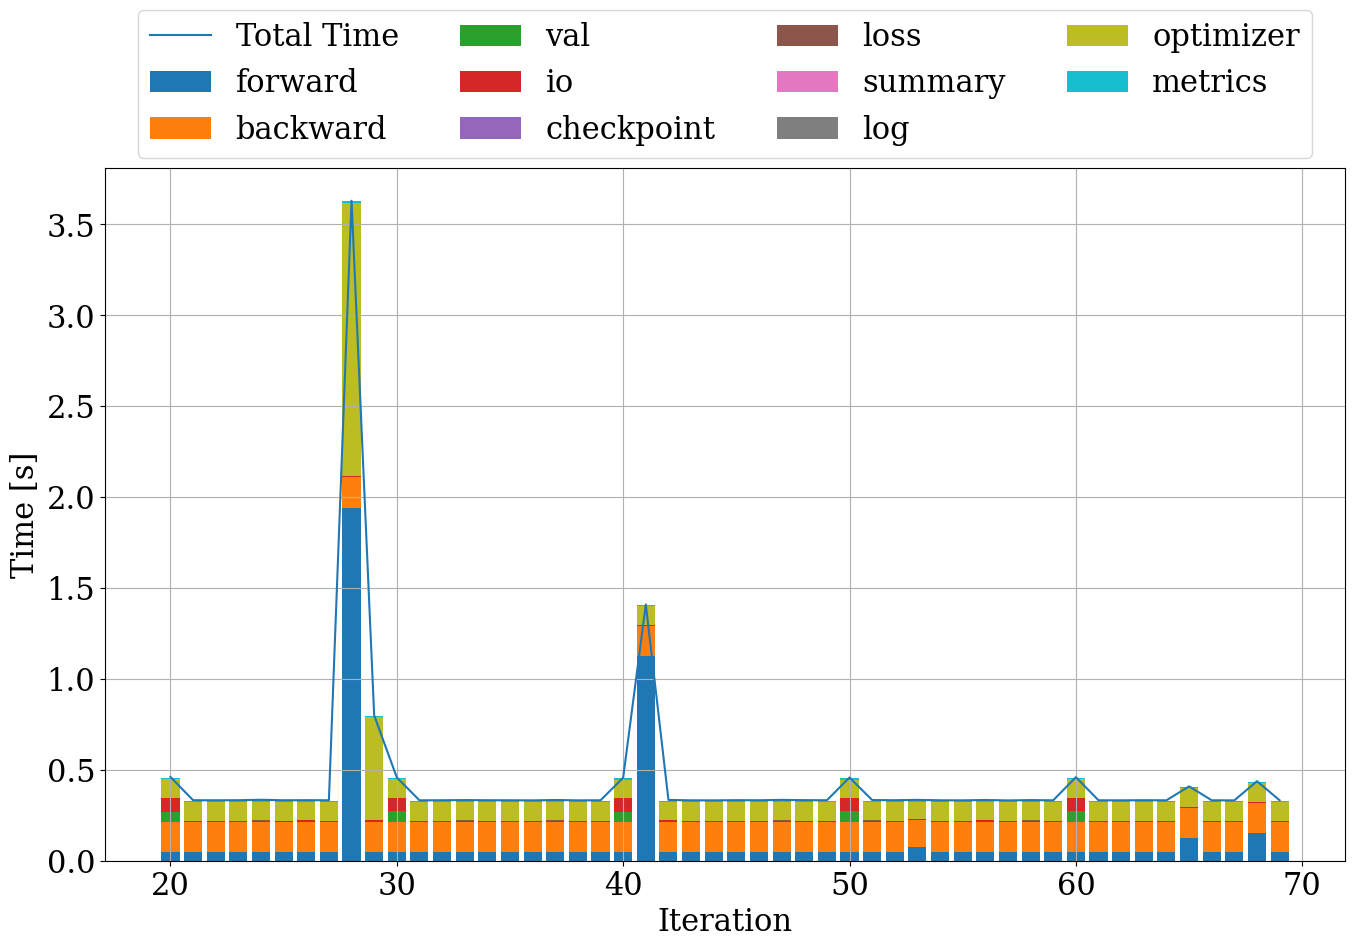

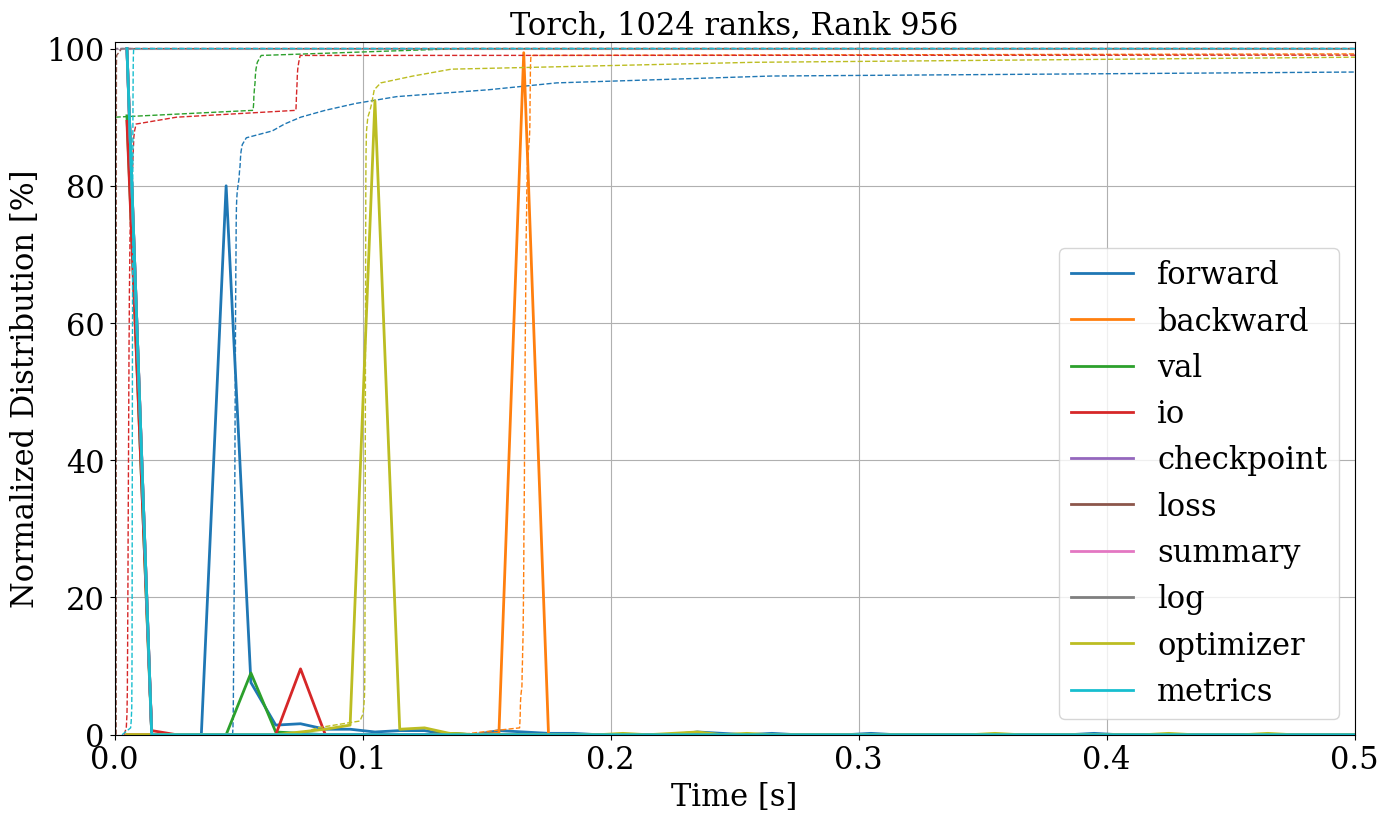

In [22]:
rank = 956
data = read_numpy_profile_data(1024,256,rank,prefix=top_dir+"/torch/scaling_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"torch_1024_256_{rank}",f"Torch, 1024 ranks, Rank {rank}", data)


## Tensorflow at Scale

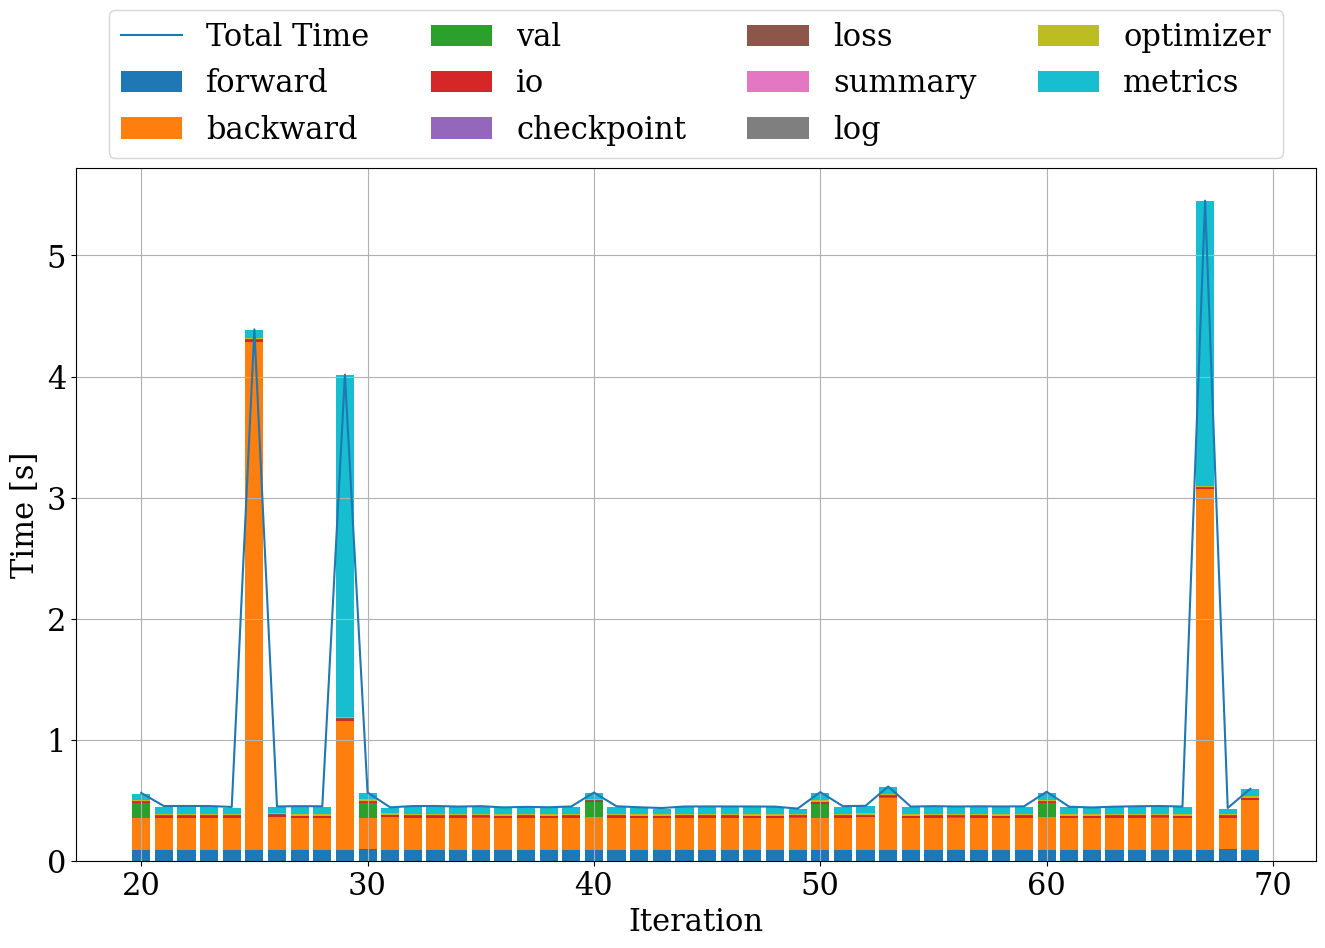

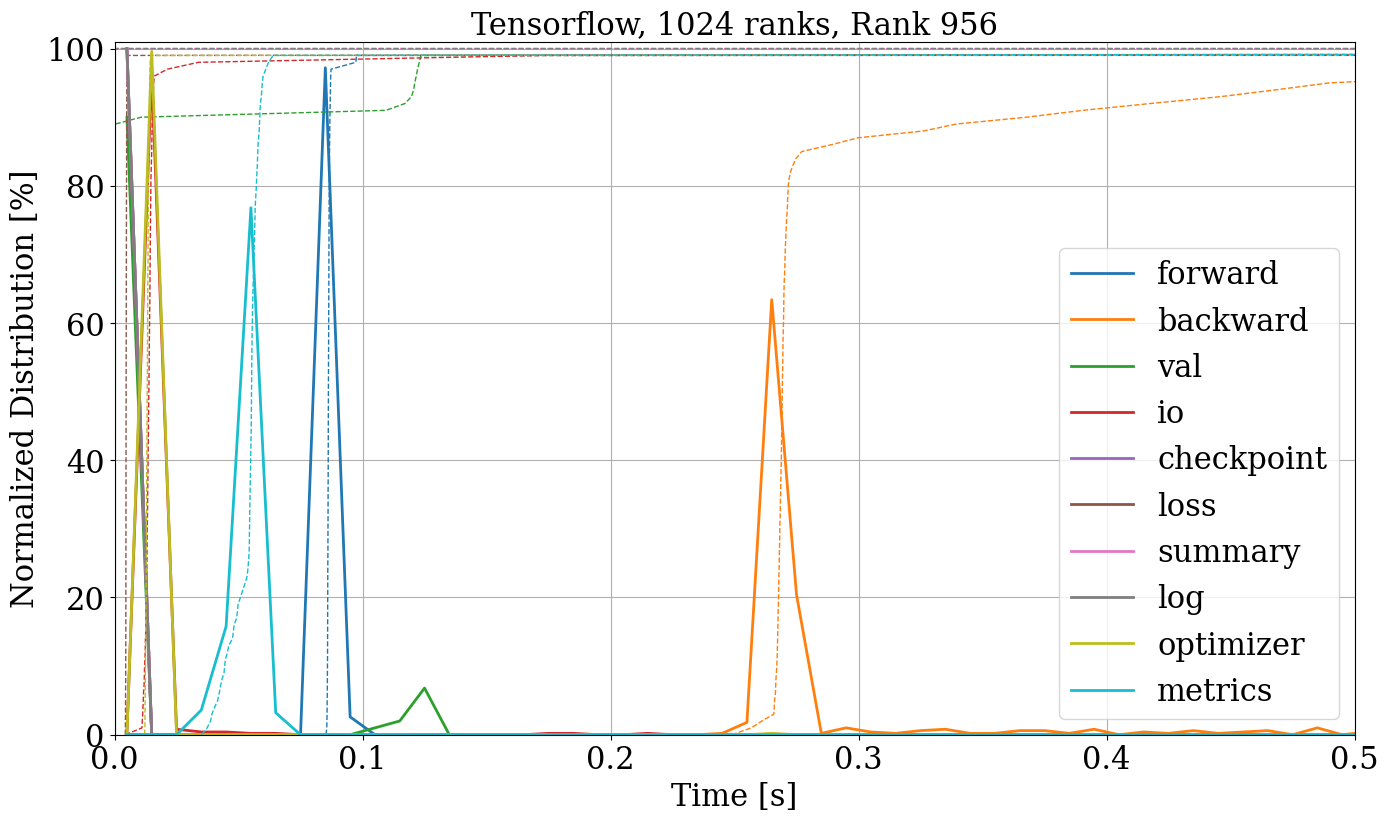

In [21]:
rank = 956
data = read_numpy_profile_data(1024,256,rank,prefix=top_dir+"/tensorflow/scaing_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"tf_1024_256_{rank}",f"Tensorflow, 1024 ranks, Rank {rank}", data)


## Pytorch even bigger

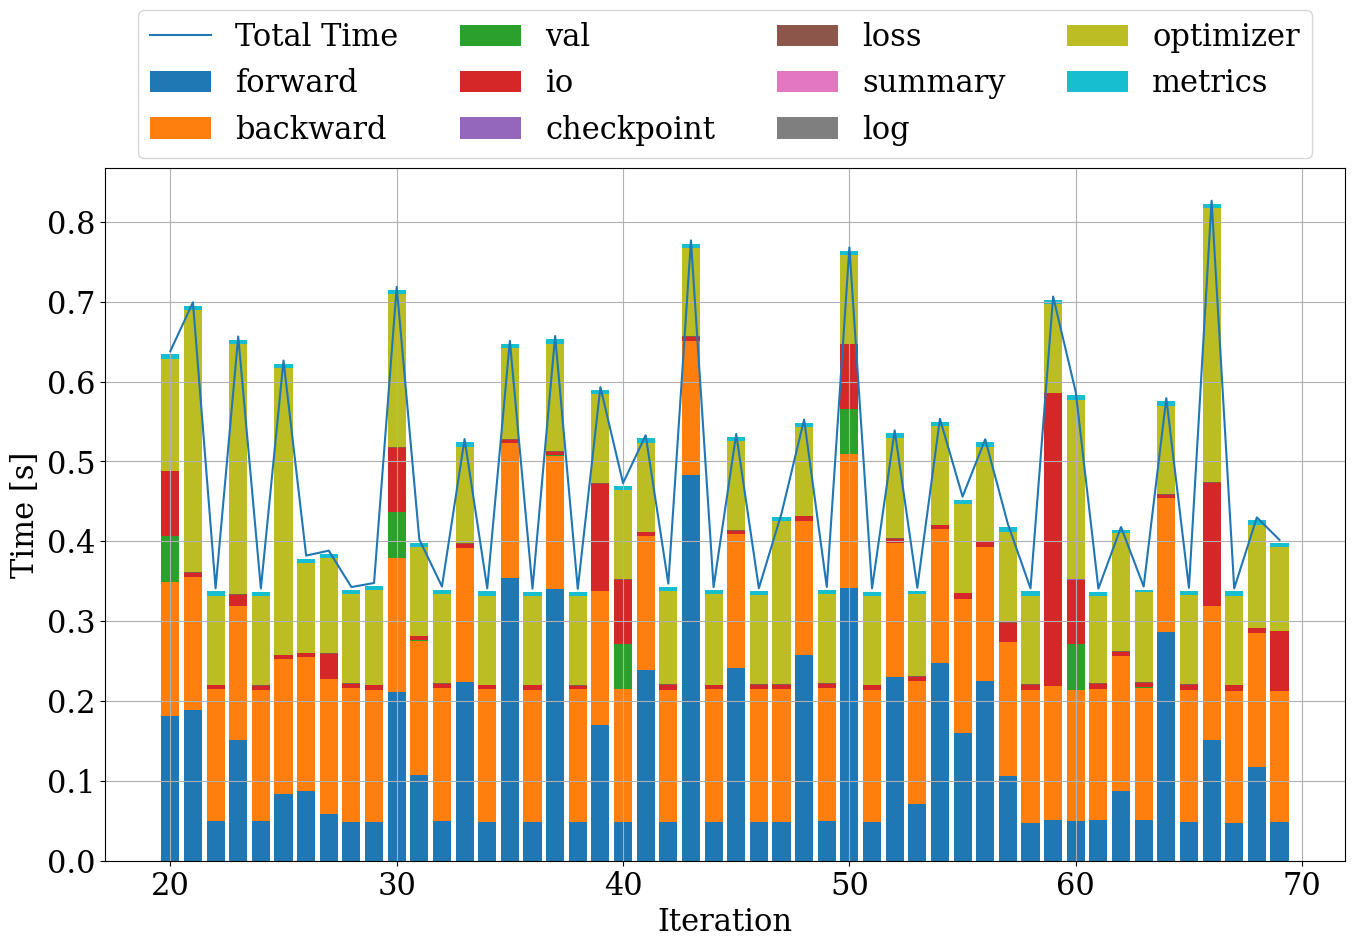

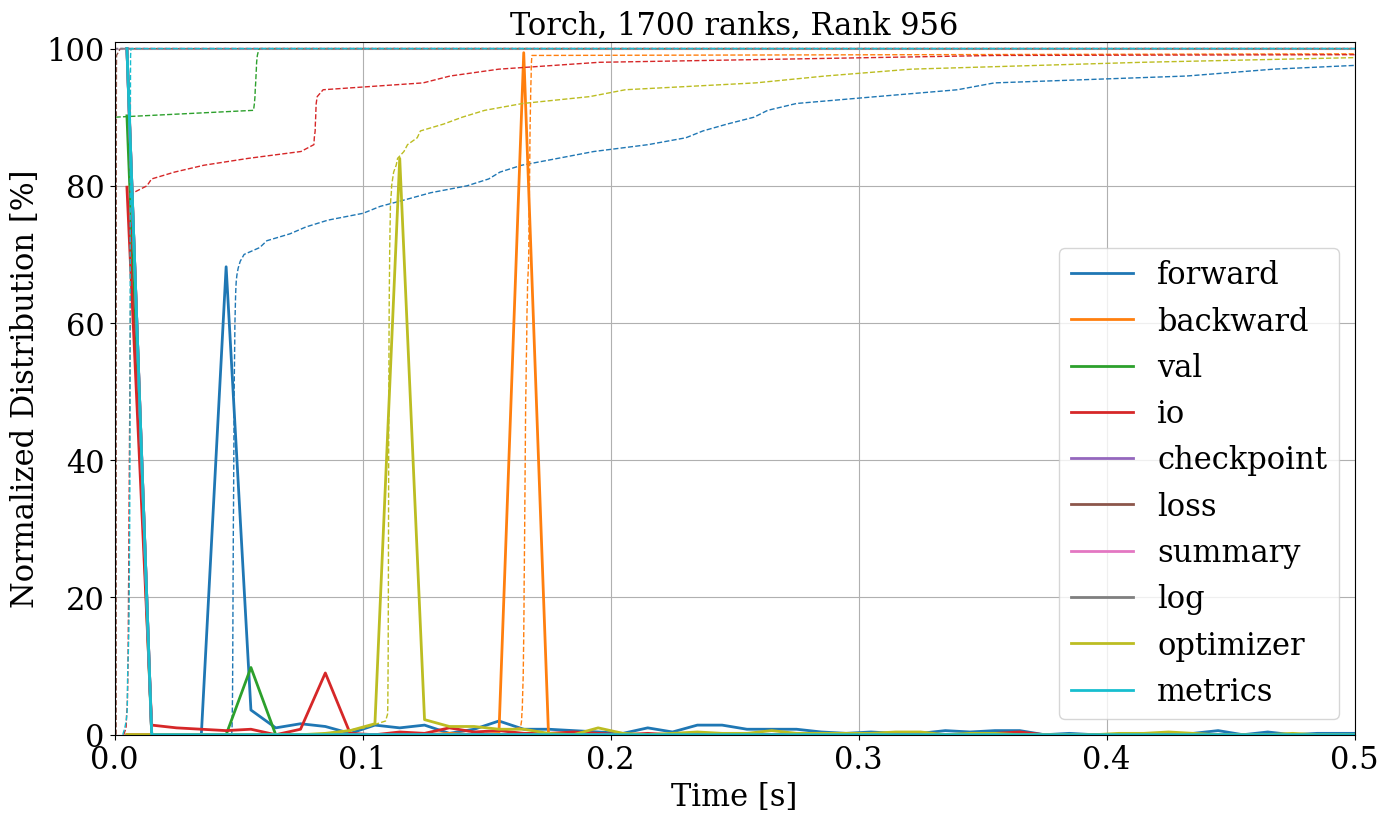

In [23]:
rank = 956
data = read_numpy_profile_data(1700,425,rank,prefix=top_dir+"/torch/scaling_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"torch_1700_425_{rank}",f"Torch, 1700 ranks, Rank {rank}", data)


Plot the scaling efficiency for each framework

In [24]:
def get_throughput(log_name):
    with open(log_name, 'r') as _f:
        lines = _f.readlines()
        for line in lines:
            if "Total time to batch process except first two" not in line: continue
            throughput = float(line.split(" ")[-1])
            return throughput

In [25]:
get_throughput(top_dir+"/torch/scaling_test_4_1/process.log")

13.4198

In [109]:
x_torch = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
y_torch = [get_throughput(top_dir+f"/torch/scaling_test_{_x}_{_x//4}/process.log") for _x in x_torch]
print(y_torch)

[13.4198, 26.4396, 52.7686, 101.7213, 207.9795, 350.6903, 685.2407, 1267.2149, 1965.283]


In [67]:
y_torch_ideal = [_x * y_torch[0]/x_torch[0] for _x in x_torch]
print(y_torch_ideal)

[13.4198, 26.8396, 53.6792, 107.3584, 214.7168, 429.4336, 858.8672, 1717.7344, 3435.4688]


In [68]:
1700*(13.4198/4)

5703.415

In [108]:
x_tf = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
y_tf = [get_throughput(top_dir+f"/tensorflow/scaing_test_{_x}_{_x//4}/process.log") for _x in x_tf]
print(y_tf)

[10.1353, 19.8495, 39.6038, 78.5957, 155.5382, 232.7284, 559.5812, 1059.4767, 1480.4712]


In [105]:
y_tf_ideal = [_x * y_tf[0]/x_tf[0] for _x in x_tf]

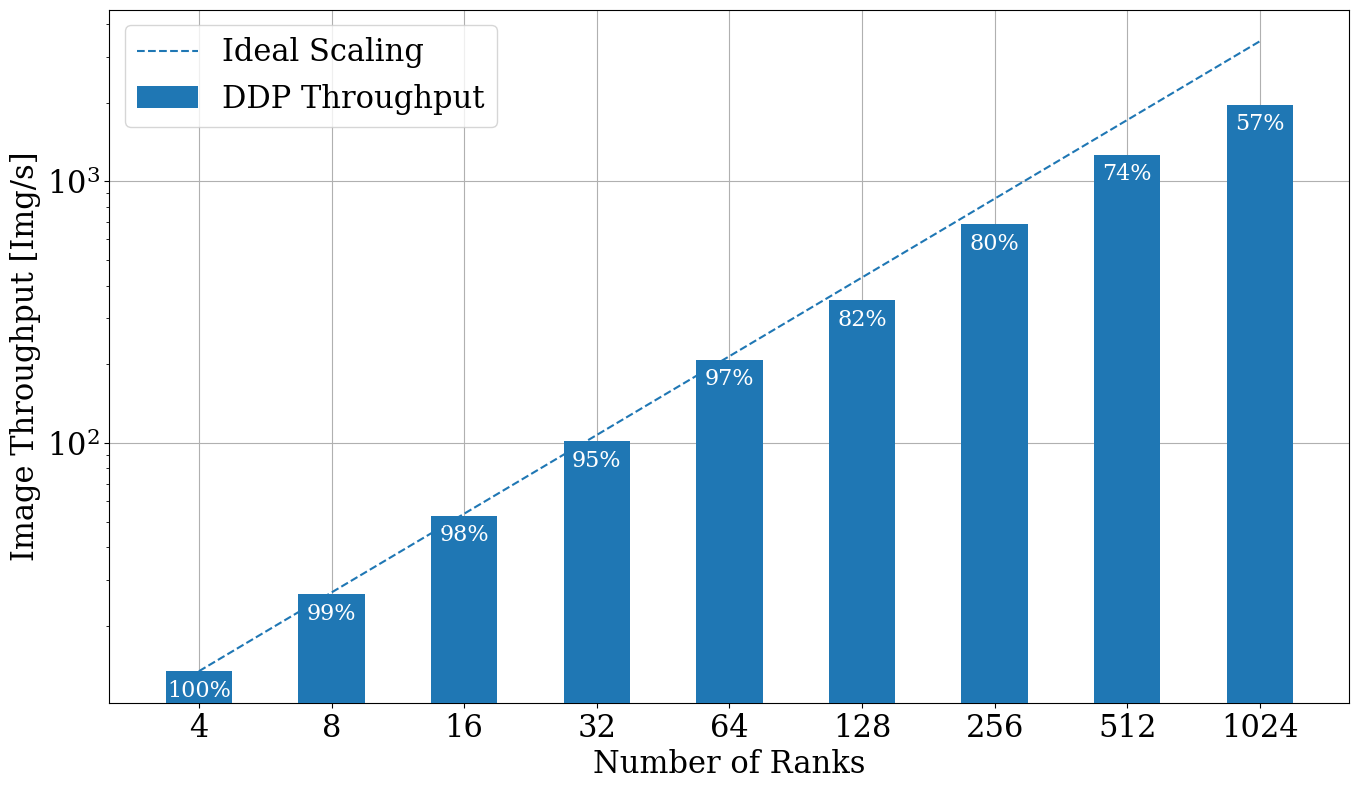

In [104]:
fig = plt.figure(figsize=(16,9))

torch_indexes = numpy.arange(len(y_torch)) 

plt.bar(torch_indexes, y_torch, width=0.5, label = "DDP Throughput", zorder=3)
plt.plot(torch_indexes, y_torch_ideal, label = "Ideal Scaling", ls="--",zorder=4)
# plt.bar(torch_indexes, y_torch_ideal,width=0.333)

# plt.xscale("log")
plt.yscale("log")
plt.ylabel("Image Throughput [Img/s]")
plt.xlabel("Number of Ranks")
plt.gca().set_xticks(torch_indexes, x_torch)

for x, y, y_ideal in zip(torch_indexes, y_torch, y_torch_ideal):
    plt.text(x, y*0.8, f"{100*y/y_ideal:.0f}%", fontsize=16, color='white', horizontalalignment='center')

plt.legend()

plt.grid(zorder=0)

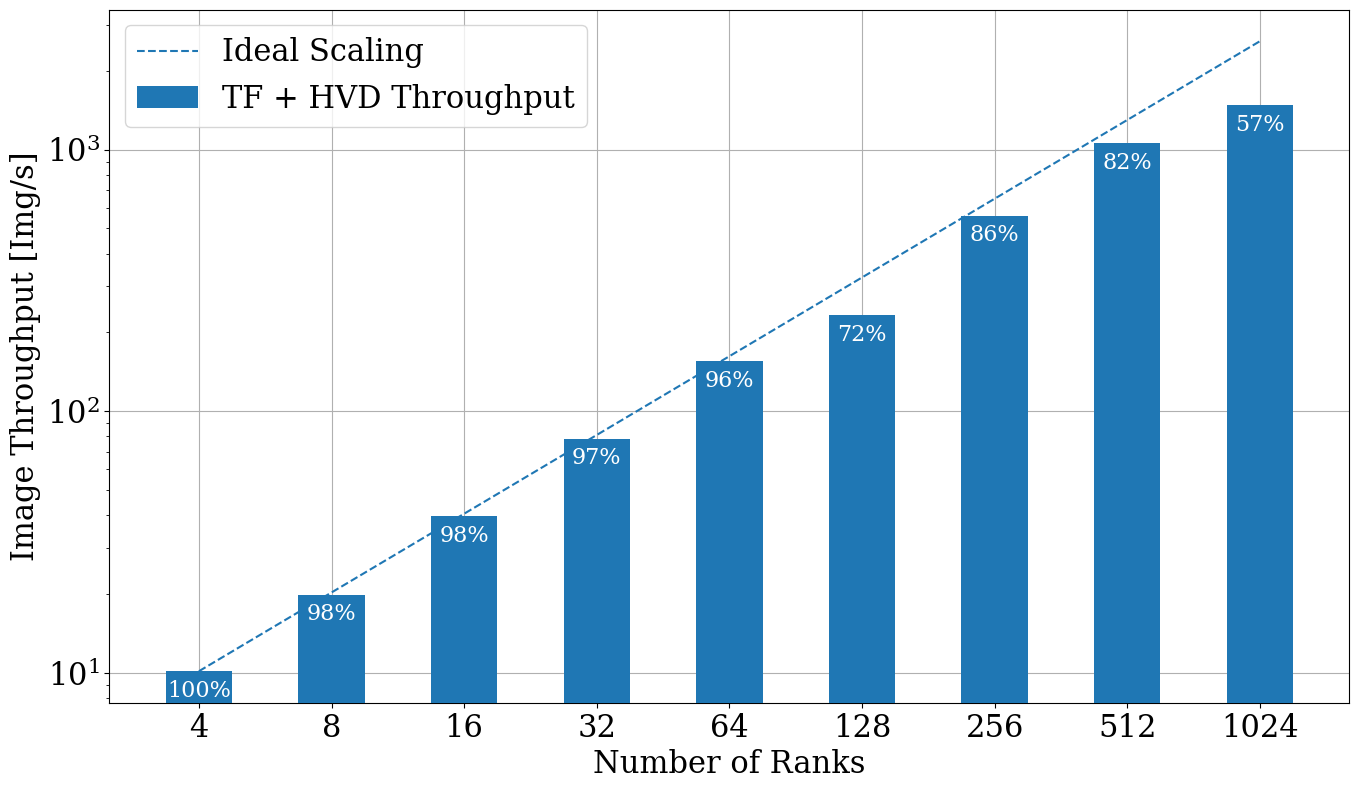

In [107]:
fig = plt.figure(figsize=(16,9))

tf_indexes = numpy.arange(len(y_tf)) 

plt.bar(tf_indexes, y_tf, width=0.5, label = "TF + HVD Throughput", zorder=3)
plt.plot(tf_indexes, y_tf_ideal, label = "Ideal Scaling", ls="--",zorder=4)
# plt.bar(torch_indexes, y_torch_ideal,width=0.333)

# plt.xscale("log")
plt.yscale("log")
plt.ylabel("Image Throughput [Img/s]")
plt.xlabel("Number of Ranks")
plt.gca().set_xticks(tf_indexes, x_tf)

for x, y, y_ideal in zip(tf_indexes, y_tf, y_tf_ideal):
    plt.text(x, y*0.8, f"{100*y/y_ideal:.0f}%", fontsize=16, color='white', horizontalalignment='center')

plt.legend()

plt.grid(zorder=0)

## Pytorch biggest scale

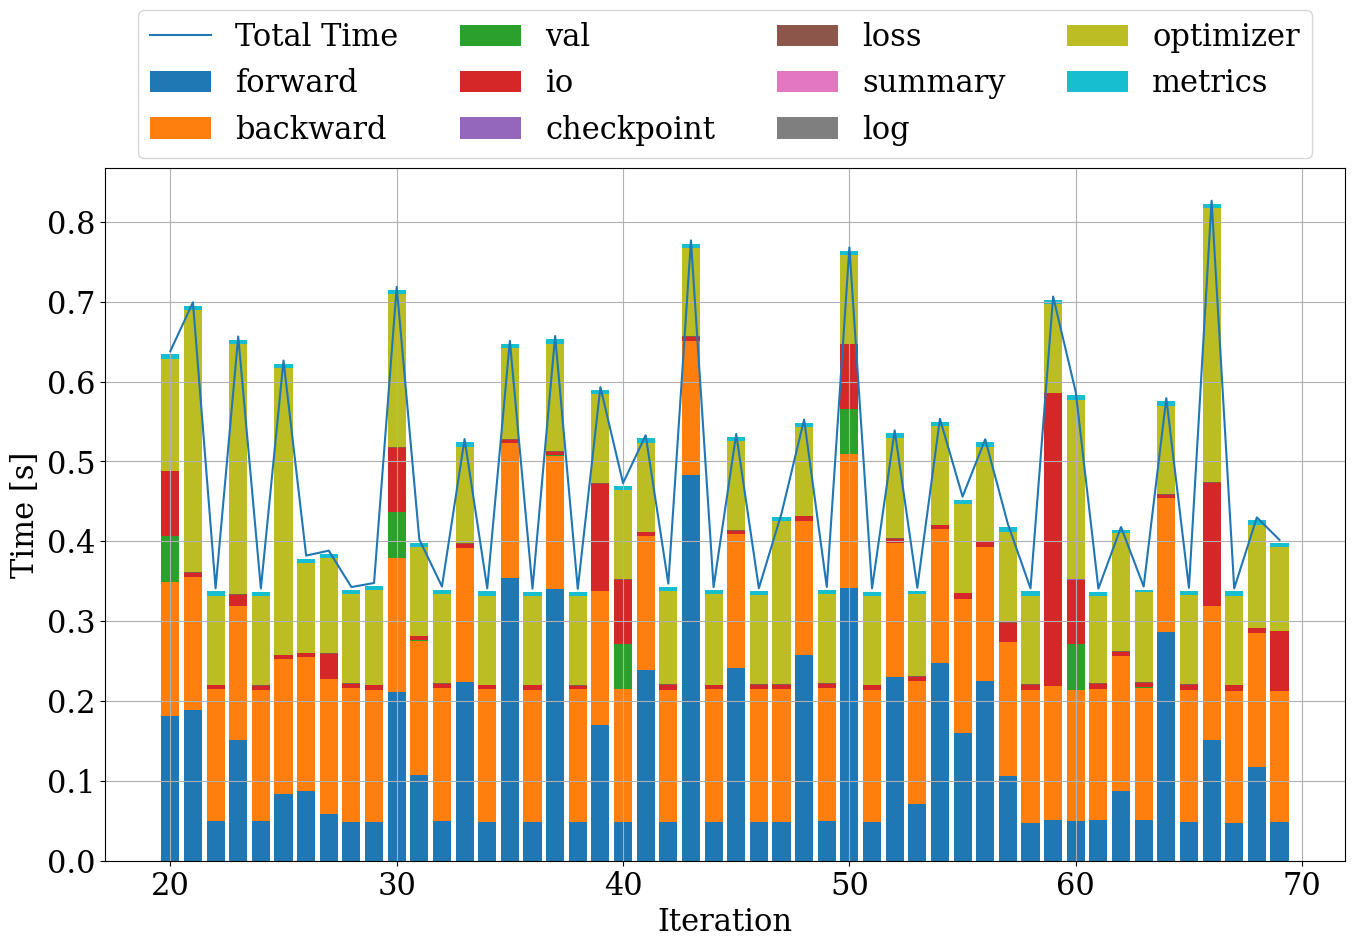

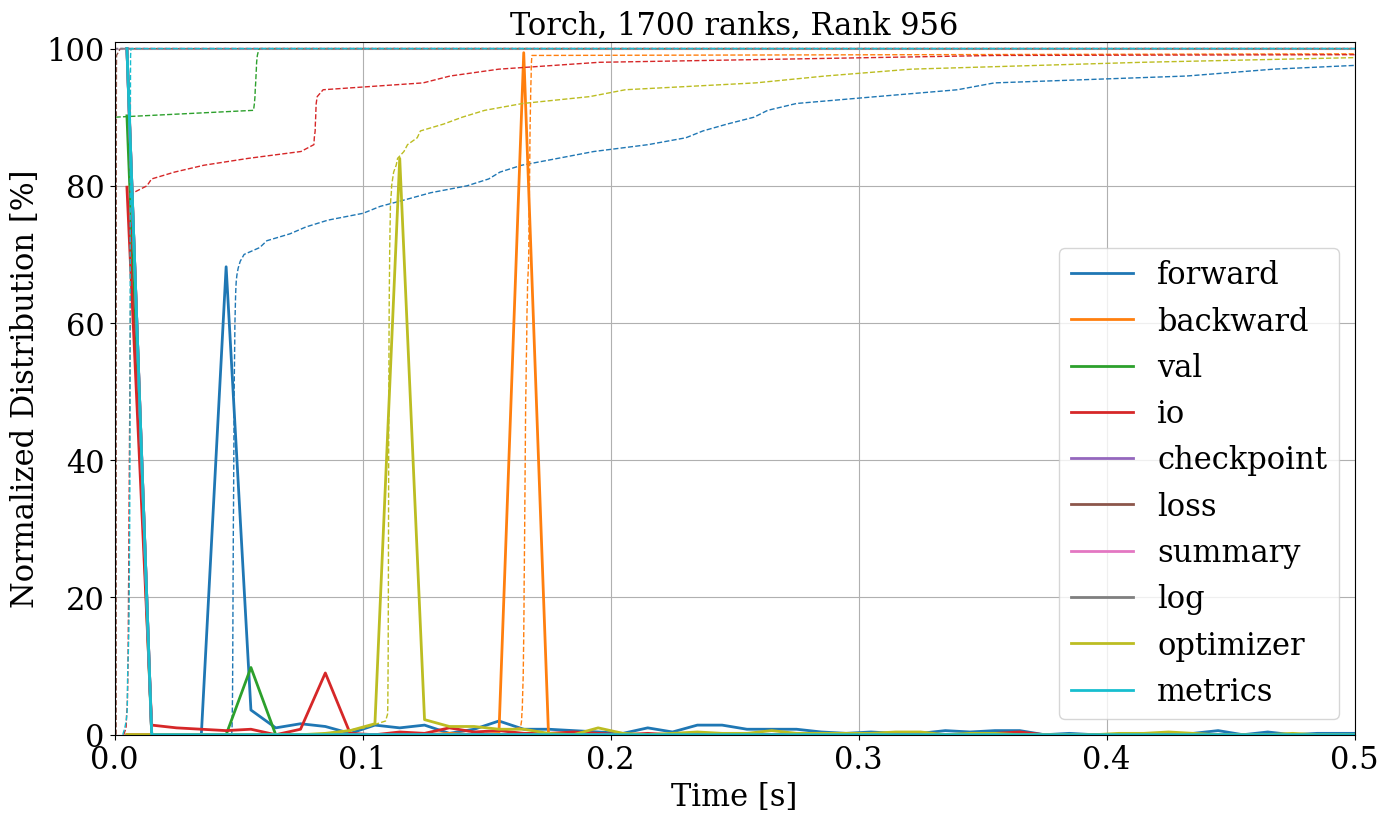

In [110]:
rank = 956
data = read_numpy_profile_data(1700,425,rank,prefix=top_dir+"/torch/scaling_test_")
make_iteration_plot(data, lims=[20,70])
plot_run_data( f"torch_1700_425_{rank}",f"Torch, 1700 ranks, Rank {rank}", data)


In [111]:
get_throughput(top_dir+"/torch/scaling_test_1700_425/process.log")

3096.9625

In [119]:
get_throughput(top_dir+"/torch/scaling_test_1700_425/process.log") / (425*y_torch[0])

0.5430014298451016

In [116]:
y_torch[0]

13.4198

In [117]:
13*425

5525